# CNN + GlobalAvgPool 
Non-coding RNA 3-4K.   
Loop over all cell lines, one at a time.

Conv1d + GlobalAvgPool1d + Dense(1).

This model learns to predict the majority class exclusively.

In [6]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-03 13:11:48.932364
Python 3.8.16
sklearn 1.0.2


In [7]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [8]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [9]:
GENES_FILE =    'CNRCI_noncoding_train_genes.csv'
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_noncoding_train_counts.K4.gc42.csv'

In [10]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [11]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq

## Model

In [12]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [13]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2023-01-03 13:11:50.056815
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [14]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

## Driver

-------------
2023-01-03 13:11:54.125660
Cell line for today: 0 = A549
Load RCI values...
Num RCI: 1447
Load genes...
2023-01-03 13:11:54.868563
Load sequence...
2023-01-03 13:11:57.049546
Num IDs: 474
Count 242 ones out of 474 labels.
Num counts: 474
2023-01-03 13:11:57.049976
splitting
Fold 1
Training example
[171 172 174 ...   0   0   0]
Train sizes (394, 3997) (394, 1)
Valid sizes (80, 3997) (80, 1)
Train set ones/size 211 / 394
Valid set ones/size 31 / 80
BUILD MODEL
COMPILE
FIT
2023-01-03 13:11:57.227913
Epoch 1/5
13/13 [==============================] - 9s 33ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6998 - val_accuracy: 0.3875
Epoch 2/5
13/13 [==============================] - 0s 9ms/step - loss: 0.6908 - accuracy: 0.5355 - val_loss: 0.7058 - val_accuracy: 0.3875
Epoch 3/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6884 - accuracy: 0.5355 - val_loss: 0.7064 - val_accuracy: 0.3875
Epoch 4/5
13/13 [==============================] - 0s 9ms/step - 

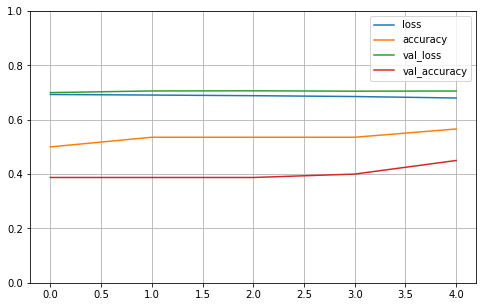

Compute valiation accuracy
2023-01-03 13:12:08.401236
Range of scores: 0.46121368 to 0.5911434
Predicted zeros and ones 7 73
Accuracy: 45.00% Precision: 41.10% Recall: 96.77% F1: 57.69%
2023-01-03 13:12:08.529426
Fold 2
Training example
[154 103 153 ...   0   0   0]
Train sizes (358, 3997) (358, 1)
Valid sizes (116, 3997) (116, 1)
Train set ones/size 183 / 358
Valid set ones/size 59 / 116
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:08.689701
Epoch 1/5
12/12 [==============================] - 1s 29ms/step - loss: 0.6933 - accuracy: 0.4944 - val_loss: 0.6930 - val_accuracy: 0.5086
Epoch 2/5
12/12 [==============================] - 0s 11ms/step - loss: 0.6933 - accuracy: 0.5112 - val_loss: 0.6926 - val_accuracy: 0.5086
Epoch 3/5
12/12 [==============================] - 0s 9ms/step - loss: 0.6915 - accuracy: 0.5140 - val_loss: 0.6922 - val_accuracy: 0.5259
Epoch 4/5
12/12 [==============================] - 0s 11ms/step - loss: 0.6902 - accuracy: 0.5950 - val_loss: 0.6909 - val_accuracy: 0.508

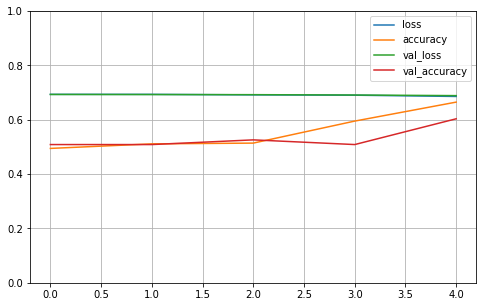

Compute valiation accuracy
2023-01-03 13:12:10.250433
Range of scores: 0.4631966 to 0.53116775
Predicted zeros and ones 35 81
Accuracy: 60.34% Precision: 58.02% Recall: 79.66% F1: 67.14%
2023-01-03 13:12:10.360227
Fold 3
Training example
[154 103 153 ...   0   0   0]
Train sizes (400, 3997) (400, 1)
Valid sizes (74, 3997) (74, 1)
Train set ones/size 205 / 400
Valid set ones/size 37 / 74
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:10.526135
Epoch 1/5
13/13 [==============================] - 1s 22ms/step - loss: 0.6935 - accuracy: 0.4875 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 2/5
13/13 [==============================] - 0s 11ms/step - loss: 0.6920 - accuracy: 0.5450 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 3/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6901 - accuracy: 0.5175 - val_loss: 0.6897 - val_accuracy: 0.5405
Epoch 4/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6859 - accuracy: 0.5675 - val_loss: 0.6854 - val_accuracy: 0.6486

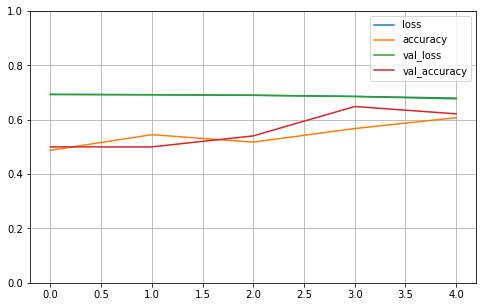

Compute valiation accuracy
2023-01-03 13:12:13.053307
Range of scores: 0.4373274 to 0.58087945
Predicted zeros and ones 25 49
Accuracy: 62.16% Precision: 59.18% Recall: 78.38% F1: 67.44%
2023-01-03 13:12:13.152041
Fold 4
Training example
[154 103 153 ...   0   0   0]
Train sizes (350, 3997) (350, 1)
Valid sizes (124, 3997) (124, 1)
Train set ones/size 173 / 350
Valid set ones/size 69 / 124
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:13.310292
Epoch 1/5
11/11 [==============================] - 1s 32ms/step - loss: 0.6940 - accuracy: 0.4914 - val_loss: 0.6907 - val_accuracy: 0.5565
Epoch 2/5
11/11 [==============================] - 0s 11ms/step - loss: 0.6938 - accuracy: 0.5114 - val_loss: 0.6925 - val_accuracy: 0.6613
Epoch 3/5
11/11 [==============================] - 0s 12ms/step - loss: 0.6926 - accuracy: 0.5257 - val_loss: 0.6921 - val_accuracy: 0.4839
Epoch 4/5
11/11 [==============================] - 0s 11ms/step - loss: 0.6922 - accuracy: 0.5143 - val_loss: 0.6915 - val_accuracy: 0.4

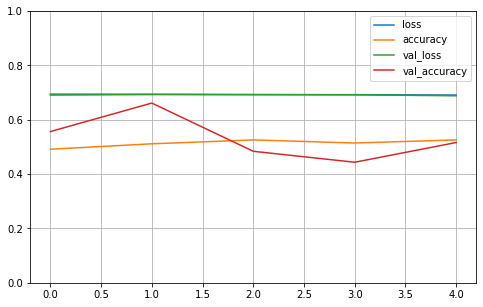

Compute valiation accuracy
2023-01-03 13:12:15.295261
Range of scores: 0.47333544 to 0.5067752
Predicted zeros and ones 111 13
Accuracy: 51.61% Precision: 84.62% Recall: 15.94% F1: 26.83%
2023-01-03 13:12:15.397655
Fold 5
Training example
[154 103 153 ...   0   0   0]
Train sizes (394, 3997) (394, 1)
Valid sizes (80, 3997) (80, 1)
Train set ones/size 196 / 394
Valid set ones/size 46 / 80
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:15.553510
Epoch 1/5
13/13 [==============================] - 1s 20ms/step - loss: 0.6941 - accuracy: 0.4772 - val_loss: 0.6904 - val_accuracy: 0.5750
Epoch 2/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6926 - accuracy: 0.5761 - val_loss: 0.6927 - val_accuracy: 0.4875
Epoch 3/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6904 - accuracy: 0.5279 - val_loss: 0.6935 - val_accuracy: 0.4250
Epoch 4/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6865 - accuracy: 0.5964 - val_loss: 0.6902 - val_accuracy: 0.500

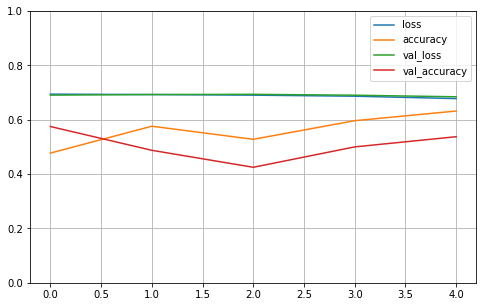

Compute valiation accuracy
2023-01-03 13:12:17.799347
Range of scores: 0.41348997 to 0.5608703
Predicted zeros and ones 53 27
Accuracy: 53.75% Precision: 66.67% Recall: 39.13% F1: 49.32%
2023-01-03 13:12:17.897598

Cross validation 5 folds 5 epochs
 accuracy mean 54.57% +/- 6.20
 precision mean 61.92% +/- 14.10
 recall mean 61.98% +/- 29.78
 F1 mean 53.68% +/- 15.01
2023-01-03 13:12:17.900451
-------------
2023-01-03 13:12:17.900508
Cell line for today: 1 = H1.hESC
Load RCI values...
Num RCI: 3327
Load genes...
2023-01-03 13:12:17.914311
Load sequence...
2023-01-03 13:12:19.274926
Num IDs: 850
Count 290 ones out of 850 labels.
Num counts: 850
2023-01-03 13:12:19.275403
splitting
Fold 1
Training example
[154 103 153 ...   0   0   0]
Train sizes (665, 3997) (665, 1)
Valid sizes (185, 3997) (185, 1)
Train set ones/size 225 / 665
Valid set ones/size 65 / 185
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:19.552075
Epoch 1/5
21/21 [==============================] - 1s 21ms/step - loss: 0.6730 - a

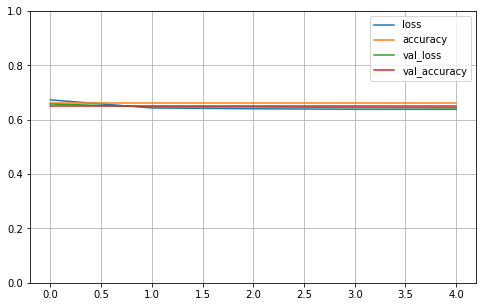

Compute valiation accuracy
2023-01-03 13:12:21.530172
Range of scores: 0.32259652 to 0.37122837
Predicted zeros and ones 185 0
Accuracy: 64.86% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:21.638914
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[154 103 153 ...   0   0   0]
Train sizes (681, 3997) (681, 1)
Valid sizes (169, 3997) (169, 1)
Train set ones/size 227 / 681
Valid set ones/size 63 / 169
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:21.904955
Epoch 1/5
22/22 [==============================] - 1s 15ms/step - loss: 0.6713 - accuracy: 0.6505 - val_loss: 0.6621 - val_accuracy: 0.6272
Epoch 2/5
22/22 [==============================] - 0s 9ms/step - loss: 0.6419 - accuracy: 0.6667 - val_loss: 0.6617 - val_accuracy: 0.6272
Epoch 3/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6369 - accuracy: 0.6667 - val_loss: 0.6625 - val_accuracy: 0.6272
Epoch 4/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6360 - accuracy: 0.6667 - val_loss: 0.6601 - val_accuracy: 0.6272
Epoch 5/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6356 - accuracy: 0.6667 - val_loss: 0.6610 - val_accuracy: 0.6272


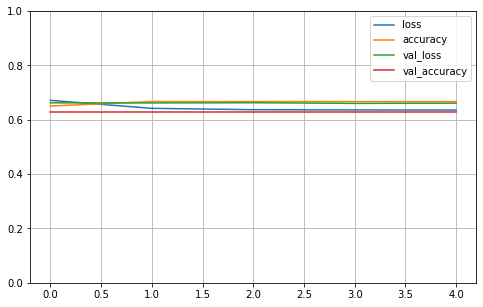

Compute valiation accuracy
2023-01-03 13:12:23.714057
Range of scores: 0.3063388 to 0.341466
Predicted zeros and ones 169 0
Accuracy: 62.72% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:23.827477
Fold 3
Training example
[154 103 153 ...   0   0   0]
Train sizes (701, 3997) (701, 1)
Valid sizes (149, 3997) (149, 1)
Train set ones/size 245 / 701
Valid set ones/size 45 / 149
BUILD MODEL


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


COMPILE
FIT
2023-01-03 13:12:24.084000
Epoch 1/5
22/22 [==============================] - 1s 17ms/step - loss: 0.6757 - accuracy: 0.6448 - val_loss: 0.6422 - val_accuracy: 0.6980
Epoch 2/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6477 - accuracy: 0.6505 - val_loss: 0.6152 - val_accuracy: 0.6980
Epoch 3/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6467 - accuracy: 0.6505 - val_loss: 0.6134 - val_accuracy: 0.6980
Epoch 4/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6449 - accuracy: 0.6505 - val_loss: 0.6157 - val_accuracy: 0.6980
Epoch 5/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6432 - accuracy: 0.6505 - val_loss: 0.6118 - val_accuracy: 0.6980


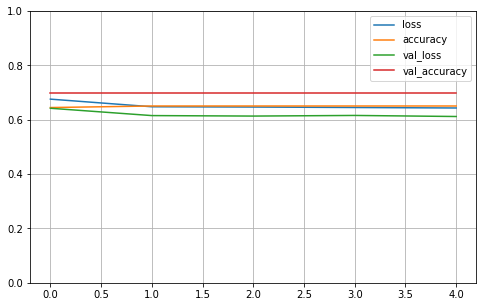

Compute valiation accuracy
2023-01-03 13:12:26.064787
Range of scores: 0.3037673 to 0.37380514
Predicted zeros and ones 149 0
Accuracy: 69.80% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:26.173779
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[171 172 174 ...   0   0   0]
Train sizes (661, 3997) (661, 1)
Valid sizes (189, 3997) (189, 1)
Train set ones/size 231 / 661
Valid set ones/size 59 / 189
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:26.412489
Epoch 1/5
21/21 [==============================] - 1s 17ms/step - loss: 0.6750 - accuracy: 0.6445 - val_loss: 0.6437 - val_accuracy: 0.6878
Epoch 2/5
21/21 [==============================] - 0s 8ms/step - loss: 0.6473 - accuracy: 0.6505 - val_loss: 0.6255 - val_accuracy: 0.6878
Epoch 3/5
21/21 [==============================] - 0s 8ms/step - loss: 0.6441 - accuracy: 0.6505 - val_loss: 0.6267 - val_accuracy: 0.6878
Epoch 4/5
21/21 [==============================] - 0s 8ms/step - loss: 0.6406 - accuracy: 0.6505 - val_loss: 0.6302 - val_accuracy: 0.6878
Epoch 5/5
21/21 [==============================] - 0s 8ms/step - loss: 0.6380 - accuracy: 0.6505 - val_loss: 0.6321 - val_accuracy: 0.6878


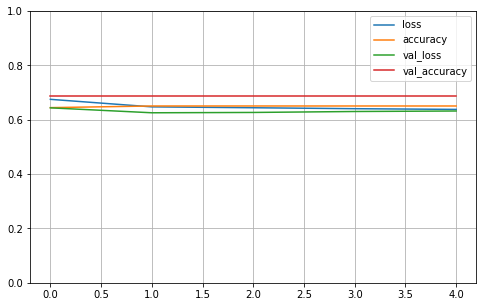

Compute valiation accuracy
2023-01-03 13:12:28.404270
Range of scores: 0.29229453 to 0.4084809
Predicted zeros and ones 189 0
Accuracy: 68.78% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:28.511471
Fold 5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[154 103 153 ...   0   0   0]
Train sizes (692, 3997) (692, 1)
Valid sizes (158, 3997) (158, 1)
Train set ones/size 232 / 692
Valid set ones/size 58 / 158
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:28.760816
Epoch 1/5
22/22 [==============================] - 1s 15ms/step - loss: 0.6753 - accuracy: 0.6647 - val_loss: 0.6620 - val_accuracy: 0.6329
Epoch 2/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6401 - accuracy: 0.6647 - val_loss: 0.6586 - val_accuracy: 0.6329
Epoch 3/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6374 - accuracy: 0.6647 - val_loss: 0.6576 - val_accuracy: 0.6329
Epoch 4/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6366 - accuracy: 0.6647 - val_loss: 0.6553 - val_accuracy: 0.6329
Epoch 5/5
22/22 [==============================] - 0s 8ms/step - loss: 0.6358 - accuracy: 0.6647 - val_loss: 0.6545 - val_accuracy: 0.6329


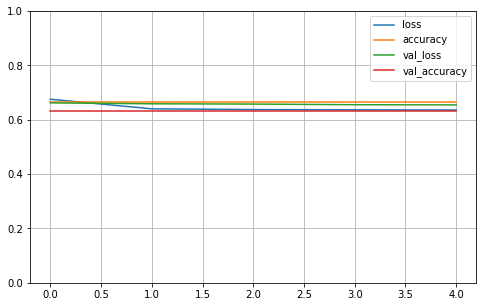

Compute valiation accuracy
2023-01-03 13:12:30.535435
Range of scores: 0.30801356 to 0.34588352
Predicted zeros and ones 158 0
Accuracy: 63.29% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:30.643010

Cross validation 5 folds 5 epochs
 accuracy mean 65.89% +/- 2.88
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:12:30.643767
-------------
2023-01-03 13:12:30.643821
Cell line for today: 2 = HeLa.S3
Load RCI values...
Num RCI: 919
Load genes...
2023-01-03 13:12:30.655641
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:12:31.223539
Num IDs: 319
Count 63 ones out of 319 labels.
Num counts: 319
2023-01-03 13:12:31.223931
splitting
Fold 1
Training example
[171 172 174 ...   0   0   0]
Train sizes (290, 3997) (290, 1)
Valid sizes (29, 3997) (29, 1)
Train set ones/size 53 / 290
Valid set ones/size 10 / 29
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:31.359378
Epoch 1/5
10/10 [==============================] - 1s 27ms/step - loss: 0.6756 - accuracy: 0.8172 - val_loss: 0.6708 - val_accuracy: 0.6552
Epoch 2/5
10/10 [==============================] - 0s 9ms/step - loss: 0.6201 - accuracy: 0.8172 - val_loss: 0.6491 - val_accuracy: 0.6552
Epoch 3/5
10/10 [==============================] - 0s 9ms/step - loss: 0.5556 - accuracy: 0.8172 - val_loss: 0.6468 - val_accuracy: 0.6552
Epoch 4/5
10/10 [==============================] - 0s 9ms/step - loss: 0.4959 - accuracy: 0.8172 - val_loss: 0.6851 - val_accuracy: 0.6552
Epoch 5/5
10/10 [==============================] - 0s 9ms/step - loss: 0.4745 - accuracy: 0

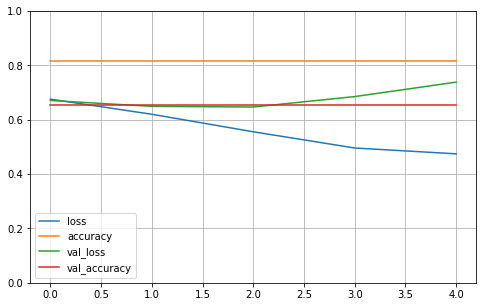

Compute valiation accuracy
2023-01-03 13:12:32.746406
Range of scores: 0.16082971 to 0.17174941
Predicted zeros and ones 29 0
Accuracy: 65.52% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:32.836007
Fold 2
Training example
[ 35 137  33 ...   0   0   0]
Train sizes (228, 3997) (228, 1)
Valid sizes (91, 3997) (91, 1)
Train set ones/size 50 / 228
Valid set ones/size 13 / 91
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:32.960552
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 36ms/step - loss: 0.6833 - accuracy: 0.7281 - val_loss: 0.6598 - val_accuracy: 0.8571
Epoch 2/5
8/8 [==============================] - 0s 11ms/step - loss: 0.6597 - accuracy: 0.7807 - val_loss: 0.6252 - val_accuracy: 0.8571
Epoch 3/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6312 - accuracy: 0.7807 - val_loss: 0.5786 - val_accuracy: 0.8571
Epoch 4/5
8/8 [==============================] - 0s 10ms/step - loss: 0.5932 - accuracy: 0.7807 - val_loss: 0.5214 - val_accuracy: 0.8571
Epoch 5/5
8/8 [==============================] - 0s 12ms/step - loss: 0.5550 - accuracy: 0.7807 - val_loss: 0.4659 - val_accuracy: 0.8571


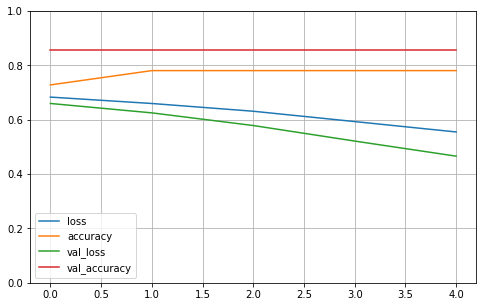

Compute valiation accuracy
2023-01-03 13:12:35.217758
Range of scores: 0.27969837 to 0.29462716
Predicted zeros and ones 91 0
Accuracy: 85.71% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:35.311745
Fold 3
Training example
[171 172 174 ...   0   0   0]
Train sizes (240, 3997) (240, 1)
Valid sizes (79, 3997) (79, 1)
Train set ones/size 38 / 240
Valid set ones/size 25 / 79
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:35.422045
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 37ms/step - loss: 0.6732 - accuracy: 0.8417 - val_loss: 0.6694 - val_accuracy: 0.6835
Epoch 2/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6217 - accuracy: 0.8417 - val_loss: 0.6451 - val_accuracy: 0.6835
Epoch 3/5
8/8 [==============================] - 0s 12ms/step - loss: 0.5618 - accuracy: 0.8417 - val_loss: 0.6279 - val_accuracy: 0.6835
Epoch 4/5
8/8 [==============================] - 0s 13ms/step - loss: 0.5040 - accuracy: 0.8417 - val_loss: 0.6319 - val_accuracy: 0.6835
Epoch 5/5
8/8 [==============================] - 0s 13ms/step - loss: 0.4585 - accuracy: 0.8417 - val_loss: 0.6643 - val_accuracy: 0.6835


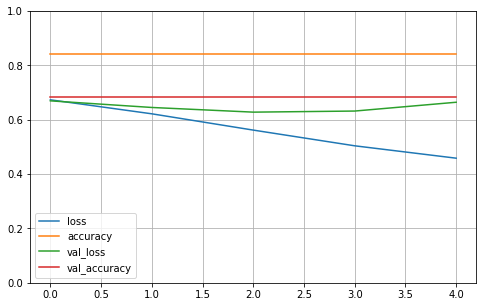

Compute valiation accuracy
2023-01-03 13:12:37.420790
Range of scores: 0.18780608 to 0.21875186
Predicted zeros and ones 79 0
Accuracy: 68.35% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:37.524199
Fold 4
Training example
[171 172 174 ...   0   0   0]
Train sizes (263, 3997) (263, 1)
Valid sizes (56, 3997) (56, 1)
Train set ones/size 60 / 263
Valid set ones/size 3 / 56
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:37.653159
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 1s 32ms/step - loss: 0.6816 - accuracy: 0.7224 - val_loss: 0.6418 - val_accuracy: 0.9464
Epoch 2/5
9/9 [==============================] - 0s 11ms/step - loss: 0.6497 - accuracy: 0.7719 - val_loss: 0.5771 - val_accuracy: 0.9464
Epoch 3/5
9/9 [==============================] - 0s 11ms/step - loss: 0.6077 - accuracy: 0.7719 - val_loss: 0.4919 - val_accuracy: 0.9464
Epoch 4/5
9/9 [==============================] - 0s 11ms/step - loss: 0.5678 - accuracy: 0.7719 - val_loss: 0.3946 - val_accuracy: 0.9464
Epoch 5/5
9/9 [==============================] - 0s 11ms/step - loss: 0.5387 - accuracy: 0.7719 - val_loss: 0.3316 - val_accuracy: 0.9464


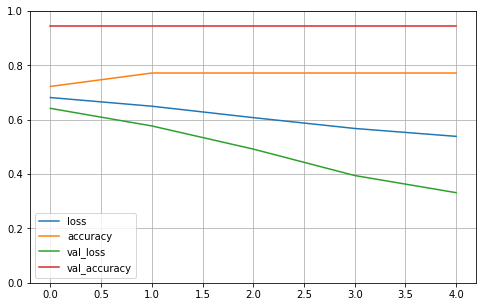

Compute valiation accuracy
2023-01-03 13:12:39.613833
Range of scores: 0.231782 to 0.24566221
Predicted zeros and ones 56 0
Accuracy: 94.64% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:39.722527
Fold 5
Training example
[171 172 174 ...   0   0   0]
Train sizes (255, 3997) (255, 1)
Valid sizes (64, 3997) (64, 1)
Train set ones/size 51 / 255
Valid set ones/size 12 / 64
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:39.841936
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 38ms/step - loss: 0.6824 - accuracy: 0.7294 - val_loss: 0.6649 - val_accuracy: 0.8125
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.6501 - accuracy: 0.8000 - val_loss: 0.6273 - val_accuracy: 0.8125
Epoch 3/5
8/8 [==============================] - 0s 13ms/step - loss: 0.6098 - accuracy: 0.8000 - val_loss: 0.5800 - val_accuracy: 0.8125
Epoch 4/5
8/8 [==============================] - 0s 14ms/step - loss: 0.5635 - accuracy: 0.8000 - val_loss: 0.5315 - val_accuracy: 0.8125
Epoch 5/5
8/8 [==============================] - 0s 13ms/step - loss: 0.5205 - accuracy: 0.8000 - val_loss: 0.4966 - val_accuracy: 0.8125


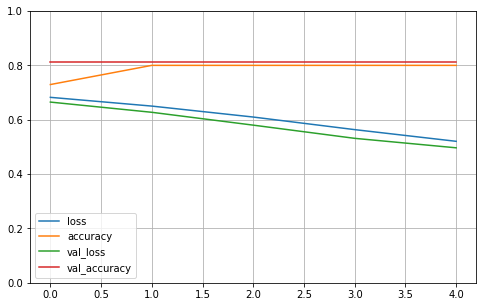

Compute valiation accuracy
2023-01-03 13:12:41.787797
Range of scores: 0.25254458 to 0.267843
Predicted zeros and ones 64 0
Accuracy: 81.25% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:41.873795

Cross validation 5 folds 5 epochs
 accuracy mean 79.10% +/- 10.86
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:12:41.875911
-------------
2023-01-03 13:12:41.875969
Cell line for today: 3 = HepG2
Load RCI values...
Num RCI: 1362
Load genes...
2023-01-03 13:12:41.888514
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:12:42.685377
Num IDs: 465
Count 105 ones out of 465 labels.
Num counts: 465
2023-01-03 13:12:42.685771
splitting
Fold 1
Training example
[154 103 153 ...   0   0   0]
Train sizes (383, 3997) (383, 1)
Valid sizes (82, 3997) (82, 1)
Train set ones/size 91 / 383
Valid set ones/size 14 / 82
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:42.843952
Epoch 1/5
12/12 [==============================] - 1s 24ms/step - loss: 0.6724 - accuracy: 0.7415 - val_loss: 0.6333 - val_accuracy: 0.8293
Epoch 2/5
12/12 [==============================] - 0s 11ms/step - loss: 0.6207 - accuracy: 0.7624 - val_loss: 0.5567 - val_accuracy: 0.8293
Epoch 3/5
12/12 [==============================] - 0s 12ms/step - loss: 0.5674 - accuracy: 0.7624 - val_loss: 0.4881 - val_accuracy: 0.8293
Epoch 4/5
12/12 [==============================] - 0s 10ms/step - loss: 0.5501 - accuracy: 0.7624 - val_loss: 0.4628 - val_accuracy: 0.8293
Epoch 5/5
12/12 [==============================] - 0s 10ms/step - loss: 0.5496 - accura

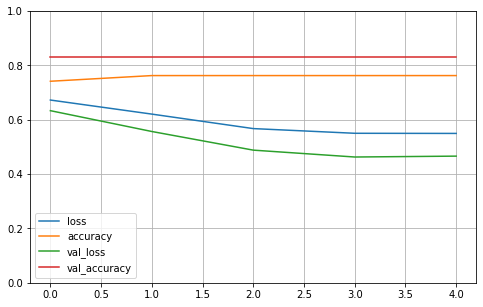

Compute valiation accuracy
2023-01-03 13:12:44.400033
Range of scores: 0.21059802 to 0.23766239
Predicted zeros and ones 82 0
Accuracy: 82.93% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:44.509042
Fold 2
Training example
[154 103 153 ...   0   0   0]
Train sizes (370, 3997) (370, 1)
Valid sizes (95, 3997) (95, 1)
Train set ones/size 88 / 370
Valid set ones/size 17 / 95
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:44.675703


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
12/12 [==============================] - 1s 24ms/step - loss: 0.6747 - accuracy: 0.7622 - val_loss: 0.6399 - val_accuracy: 0.8211
Epoch 2/5
12/12 [==============================] - 0s 11ms/step - loss: 0.6253 - accuracy: 0.7622 - val_loss: 0.5670 - val_accuracy: 0.8211
Epoch 3/5
12/12 [==============================] - 0s 11ms/step - loss: 0.5733 - accuracy: 0.7622 - val_loss: 0.5038 - val_accuracy: 0.8211
Epoch 4/5
12/12 [==============================] - 0s 9ms/step - loss: 0.5526 - accuracy: 0.7622 - val_loss: 0.4764 - val_accuracy: 0.8211
Epoch 5/5
12/12 [==============================] - 0s 9ms/step - loss: 0.5495 - accuracy: 0.7622 - val_loss: 0.4751 - val_accuracy: 0.8211


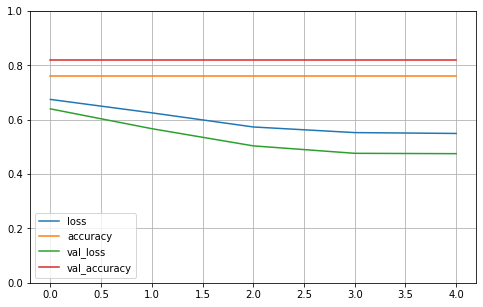

Compute valiation accuracy
2023-01-03 13:12:46.630656
Range of scores: 0.21145096 to 0.2232484
Predicted zeros and ones 95 0
Accuracy: 82.11% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:46.728492
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[171 172 174 ...   0   0   0]
Train sizes (326, 3997) (326, 1)
Valid sizes (139, 3997) (139, 1)
Train set ones/size 72 / 326
Valid set ones/size 33 / 139
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:46.882679
Epoch 1/5
11/11 [==============================] - 1s 27ms/step - loss: 0.6754 - accuracy: 0.7209 - val_loss: 0.6536 - val_accuracy: 0.7626
Epoch 2/5
11/11 [==============================] - 0s 11ms/step - loss: 0.6258 - accuracy: 0.7791 - val_loss: 0.6055 - val_accuracy: 0.7626
Epoch 3/5
11/11 [==============================] - 0s 12ms/step - loss: 0.5745 - accuracy: 0.7791 - val_loss: 0.5621 - val_accuracy: 0.7626
Epoch 4/5
11/11 [==============================] - 0s 11ms/step - loss: 0.5320 - accuracy: 0.7791 - val_loss: 0.5505 - val_accuracy: 0.7626
Epoch 5/5
11/11 [==============================] - 0s 10ms/step - loss: 0.5268 - accuracy: 0.7791 - val_loss: 0.5554 - val_accuracy: 0.7626


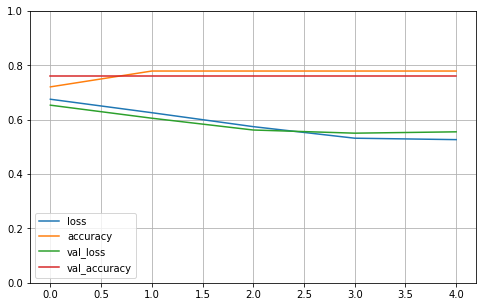

Compute valiation accuracy
2023-01-03 13:12:48.406558
Range of scores: 0.18214616 to 0.21476114
Predicted zeros and ones 139 0
Accuracy: 76.26% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:48.522692
Fold 4
Training example
[154 103 153 ...   0   0   0]
Train sizes (378, 3997) (378, 1)
Valid sizes (87, 3997) (87, 1)
Train set ones/size 78 / 378
Valid set ones/size 27 / 87
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:48.689226


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
12/12 [==============================] - 1s 26ms/step - loss: 0.6714 - accuracy: 0.7407 - val_loss: 0.6611 - val_accuracy: 0.6897
Epoch 2/5
12/12 [==============================] - 0s 11ms/step - loss: 0.6139 - accuracy: 0.7937 - val_loss: 0.6265 - val_accuracy: 0.6897
Epoch 3/5
12/12 [==============================] - 0s 12ms/step - loss: 0.5461 - accuracy: 0.7937 - val_loss: 0.6197 - val_accuracy: 0.6897
Epoch 4/5
12/12 [==============================] - 0s 11ms/step - loss: 0.5139 - accuracy: 0.7937 - val_loss: 0.6544 - val_accuracy: 0.6897
Epoch 5/5
12/12 [==============================] - 0s 10ms/step - loss: 0.5131 - accuracy: 0.7937 - val_loss: 0.6637 - val_accuracy: 0.6897


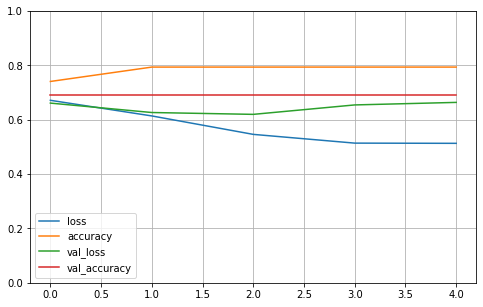

Compute valiation accuracy
2023-01-03 13:12:50.244692
Range of scores: 0.17399007 to 0.19332139
Predicted zeros and ones 87 0
Accuracy: 68.97% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:50.365964
Fold 5
Training example
[154 103 153 ...   0   0   0]
Train sizes (403, 3997) (403, 1)
Valid sizes (62, 3997) (62, 1)
Train set ones/size 91 / 403
Valid set ones/size 14 / 62
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:50.537785


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
13/13 [==============================] - 1s 24ms/step - loss: 0.6722 - accuracy: 0.7543 - val_loss: 0.6416 - val_accuracy: 0.7742
Epoch 2/5
13/13 [==============================] - 0s 9ms/step - loss: 0.6125 - accuracy: 0.7742 - val_loss: 0.5775 - val_accuracy: 0.7742
Epoch 3/5
13/13 [==============================] - 0s 9ms/step - loss: 0.5561 - accuracy: 0.7742 - val_loss: 0.5379 - val_accuracy: 0.7742
Epoch 4/5
13/13 [==============================] - 0s 10ms/step - loss: 0.5324 - accuracy: 0.7742 - val_loss: 0.5363 - val_accuracy: 0.7742
Epoch 5/5
13/13 [==============================] - 0s 9ms/step - loss: 0.5347 - accuracy: 0.7742 - val_loss: 0.5372 - val_accuracy: 0.7742


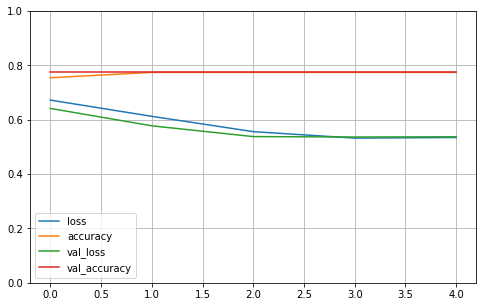

Compute valiation accuracy
2023-01-03 13:12:52.787185
Range of scores: 0.19388697 to 0.21708086
Predicted zeros and ones 62 0
Accuracy: 77.42% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:52.883841

Cross validation 5 folds 5 epochs
 accuracy mean 77.54% +/- 5.00
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:12:52.884556
-------------
2023-01-03 13:12:52.884617
Cell line for today: 4 = HT1080
Load RCI values...
Num RCI: 936
Load genes...
2023-01-03 13:12:52.897440
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:12:53.828182
Num IDs: 421
Count 167 ones out of 421 labels.
Num counts: 421
2023-01-03 13:12:53.828600
splitting
Fold 1
Training example
[154 103 153 ...   0   0   0]
Train sizes (345, 3997) (345, 1)
Valid sizes (76, 3997) (76, 1)
Train set ones/size 143 / 345
Valid set ones/size 24 / 76
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:53.978157
Epoch 1/5
11/11 [==============================] - 1s 28ms/step - loss: 0.6897 - accuracy: 0.5826 - val_loss: 0.6739 - val_accuracy: 0.6842
Epoch 2/5
11/11 [==============================] - 0s 12ms/step - loss: 0.6832 - accuracy: 0.5855 - val_loss: 0.6558 - val_accuracy: 0.6842
Epoch 3/5
11/11 [==============================] - 0s 24ms/step - loss: 0.6796 - accuracy: 0.5855 - val_loss: 0.6436 - val_accuracy: 0.6842
Epoch 4/5
11/11 [==============================] - 0s 15ms/step - loss: 0.6783 - accuracy: 0.5855 - val_loss: 0.6406 - val_accuracy: 0.6842
Epoch 5/5
11/11 [==============================] - 0s 12ms/step - loss: 0.6784 - accur

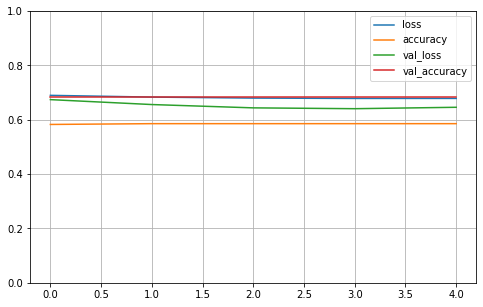

Compute valiation accuracy
2023-01-03 13:12:55.878599
Range of scores: 0.4137763 to 0.42592058
Predicted zeros and ones 76 0
Accuracy: 68.42% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:55.991756
Fold 2
Training example
[154 103 153 ...   0   0   0]
Train sizes (331, 3997) (331, 1)
Valid sizes (90, 3997) (90, 1)
Train set ones/size 108 / 331
Valid set ones/size 59 / 90
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:56.141062


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
11/11 [==============================] - 1s 26ms/step - loss: 0.6835 - accuracy: 0.6737 - val_loss: 0.7252 - val_accuracy: 0.3444
Epoch 2/5
11/11 [==============================] - 0s 11ms/step - loss: 0.6581 - accuracy: 0.6737 - val_loss: 0.7728 - val_accuracy: 0.3444
Epoch 3/5
11/11 [==============================] - 0s 10ms/step - loss: 0.6388 - accuracy: 0.6737 - val_loss: 0.8342 - val_accuracy: 0.3444
Epoch 4/5
11/11 [==============================] - 0s 12ms/step - loss: 0.6305 - accuracy: 0.6737 - val_loss: 0.8769 - val_accuracy: 0.3444
Epoch 5/5
11/11 [==============================] - 0s 10ms/step - loss: 0.6302 - accuracy: 0.6737 - val_loss: 0.8773 - val_accuracy: 0.3444


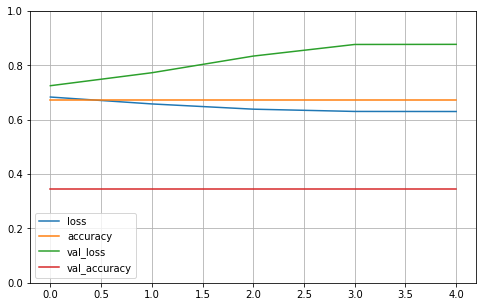

Compute valiation accuracy
2023-01-03 13:12:57.684752
Range of scores: 0.3155902 to 0.33592367
Predicted zeros and ones 90 0
Accuracy: 34.44% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:57.791529
Fold 3
Training example
[154 103 153 ...   0   0   0]
Train sizes (338, 3997) (338, 1)
Valid sizes (83, 3997) (83, 1)
Train set ones/size 141 / 338
Valid set ones/size 26 / 83
BUILD MODEL
COMPILE
FIT
2023-01-03 13:12:57.939402
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11/11 [==============================] - 1s 23ms/step - loss: 0.6895 - accuracy: 0.5799 - val_loss: 0.6736 - val_accuracy: 0.6867
Epoch 2/5
11/11 [==============================] - 0s 10ms/step - loss: 0.6837 - accuracy: 0.5828 - val_loss: 0.6582 - val_accuracy: 0.6867
Epoch 3/5
11/11 [==============================] - 0s 11ms/step - loss: 0.6798 - accuracy: 0.5828 - val_loss: 0.6483 - val_accuracy: 0.6867
Epoch 4/5
11/11 [==============================] - 0s 10ms/step - loss: 0.6787 - accuracy: 0.5828 - val_loss: 0.6435 - val_accuracy: 0.6867
Epoch 5/5
11/11 [==============================] - 0s 10ms/step - loss: 0.6787 - accuracy: 0.5828 - val_loss: 0.6399 - val_accuracy: 0.6867


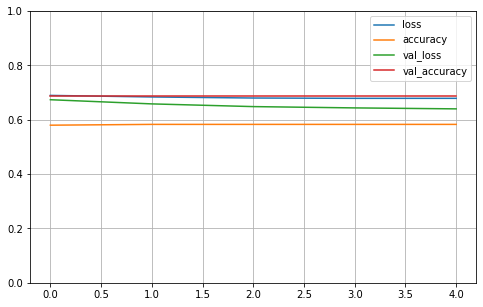

Compute valiation accuracy
2023-01-03 13:12:59.885004
Range of scores: 0.39718044 to 0.41219595
Predicted zeros and ones 83 0
Accuracy: 68.67% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:12:59.981190
Fold 4
Training example
[154 103 153 ...   0   0   0]
Train sizes (340, 3997) (340, 1)
Valid sizes (81, 3997) (81, 1)
Train set ones/size 139 / 340
Valid set ones/size 28 / 81
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:00.128762
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11/11 [==============================] - 1s 27ms/step - loss: 0.6897 - accuracy: 0.5794 - val_loss: 0.6792 - val_accuracy: 0.6543
Epoch 2/5
11/11 [==============================] - 0s 11ms/step - loss: 0.6822 - accuracy: 0.5912 - val_loss: 0.6630 - val_accuracy: 0.6543
Epoch 3/5
11/11 [==============================] - 0s 11ms/step - loss: 0.6768 - accuracy: 0.5912 - val_loss: 0.6555 - val_accuracy: 0.6543
Epoch 4/5
11/11 [==============================] - 0s 12ms/step - loss: 0.6766 - accuracy: 0.5912 - val_loss: 0.6513 - val_accuracy: 0.6543
Epoch 5/5
11/11 [==============================] - 0s 11ms/step - loss: 0.6759 - accuracy: 0.5912 - val_loss: 0.6511 - val_accuracy: 0.6543


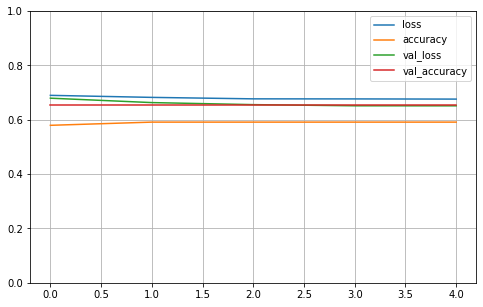

Compute valiation accuracy
2023-01-03 13:13:02.080934
Range of scores: 0.39541617 to 0.41034138
Predicted zeros and ones 81 0
Accuracy: 65.43% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:02.179358
Fold 5
Training example
[171 172 174 ...   0   0   0]
Train sizes (330, 3997) (330, 1)
Valid sizes (91, 3997) (91, 1)
Train set ones/size 137 / 330
Valid set ones/size 30 / 91
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:02.318777
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11/11 [==============================] - 1s 23ms/step - loss: 0.6900 - accuracy: 0.5606 - val_loss: 0.6759 - val_accuracy: 0.6703
Epoch 2/5
11/11 [==============================] - 0s 10ms/step - loss: 0.6835 - accuracy: 0.5848 - val_loss: 0.6650 - val_accuracy: 0.6703
Epoch 3/5
11/11 [==============================] - 0s 11ms/step - loss: 0.6798 - accuracy: 0.5848 - val_loss: 0.6546 - val_accuracy: 0.6703
Epoch 4/5
11/11 [==============================] - 0s 11ms/step - loss: 0.6795 - accuracy: 0.5848 - val_loss: 0.6455 - val_accuracy: 0.6703
Epoch 5/5
11/11 [==============================] - 0s 10ms/step - loss: 0.6799 - accuracy: 0.5848 - val_loss: 0.6522 - val_accuracy: 0.6703


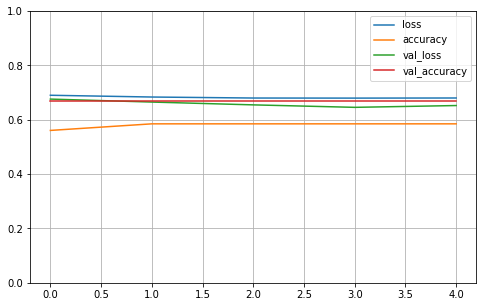

Compute valiation accuracy
2023-01-03 13:13:04.283874
Range of scores: 0.42030716 to 0.4293117
Predicted zeros and ones 91 0
Accuracy: 67.03% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:04.390547

Cross validation 5 folds 5 epochs
 accuracy mean 60.80% +/- 13.23
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:13:04.391172
-------------
2023-01-03 13:13:04.391227
Cell line for today: 5 = HUVEC
Load RCI values...
Num RCI: 1488
Load genes...
2023-01-03 13:13:04.405239
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:13:05.285929
Num IDs: 533
Count 158 ones out of 533 labels.
Num counts: 533
2023-01-03 13:13:05.286726
splitting
Fold 1
Training example
[133  18  72 ...   0   0   0]
Train sizes (419, 3997) (419, 1)
Valid sizes (114, 3997) (114, 1)
Train set ones/size 121 / 419
Valid set ones/size 37 / 114
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:05.459944
Epoch 1/5
14/14 [==============================] - 1s 23ms/step - loss: 0.6741 - accuracy: 0.7136 - val_loss: 0.6605 - val_accuracy: 0.6754
Epoch 2/5
14/14 [==============================] - 0s 10ms/step - loss: 0.6339 - accuracy: 0.7112 - val_loss: 0.6371 - val_accuracy: 0.6754
Epoch 3/5
14/14 [==============================] - 0s 10ms/step - loss: 0.6069 - accuracy: 0.7112 - val_loss: 0.6352 - val_accuracy: 0.6754
Epoch 4/5
14/14 [==============================] - 0s 11ms/step - loss: 0.6009 - accuracy: 0.7112 - val_loss: 0.6374 - val_accuracy: 0.6754
Epoch 5/5
14/14 [==============================] - 0s 11ms/step - loss: 0.6013 - ac

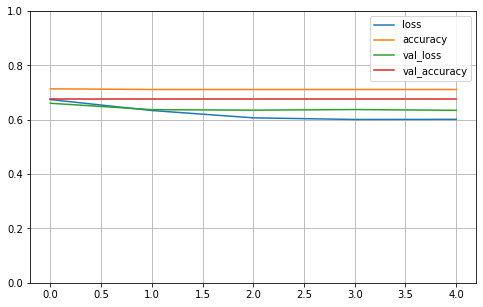

Compute valiation accuracy
2023-01-03 13:13:07.458442
Range of scores: 0.294426 to 0.32407093
Predicted zeros and ones 114 0
Accuracy: 67.54% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:07.576441
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[154 103 153 ...   0   0   0]
Train sizes (400, 3997) (400, 1)
Valid sizes (133, 3997) (133, 1)
Train set ones/size 118 / 400
Valid set ones/size 40 / 133
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:07.744080
Epoch 1/5
13/13 [==============================] - 1s 24ms/step - loss: 0.6769 - accuracy: 0.7000 - val_loss: 0.6610 - val_accuracy: 0.6992
Epoch 2/5
13/13 [==============================] - 0s 11ms/step - loss: 0.6431 - accuracy: 0.7050 - val_loss: 0.6269 - val_accuracy: 0.6992
Epoch 3/5
13/13 [==============================] - 0s 11ms/step - loss: 0.6150 - accuracy: 0.7050 - val_loss: 0.6120 - val_accuracy: 0.6992
Epoch 4/5
13/13 [==============================] - 0s 11ms/step - loss: 0.6083 - accuracy: 0.7050 - val_loss: 0.6132 - val_accuracy: 0.6992
Epoch 5/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6073 - accuracy: 0.7050 - val_loss: 0.6118 - val_accuracy: 0.6992


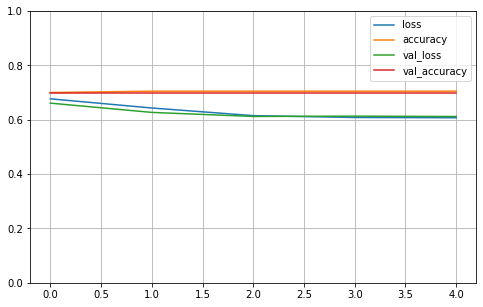

Compute valiation accuracy
2023-01-03 13:13:10.011473
Range of scores: 0.29537725 to 0.30099452
Predicted zeros and ones 133 0
Accuracy: 69.92% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:10.117272
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[154 103 153 ...   0   0   0]
Train sizes (421, 3997) (421, 1)
Valid sizes (112, 3997) (112, 1)
Train set ones/size 122 / 421
Valid set ones/size 36 / 112
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:10.290684
Epoch 1/5
14/14 [==============================] - 1s 22ms/step - loss: 0.6737 - accuracy: 0.7031 - val_loss: 0.6570 - val_accuracy: 0.6786
Epoch 2/5
14/14 [==============================] - 0s 12ms/step - loss: 0.6292 - accuracy: 0.7102 - val_loss: 0.6291 - val_accuracy: 0.6786
Epoch 3/5
14/14 [==============================] - 0s 11ms/step - loss: 0.6036 - accuracy: 0.7102 - val_loss: 0.6330 - val_accuracy: 0.6786
Epoch 4/5
14/14 [==============================] - 0s 12ms/step - loss: 0.6037 - accuracy: 0.7102 - val_loss: 0.6362 - val_accuracy: 0.6786
Epoch 5/5
14/14 [==============================] - 0s 11ms/step - loss: 0.6016 - accuracy: 0.7102 - val_loss: 0.6313 - val_accuracy: 0.6786


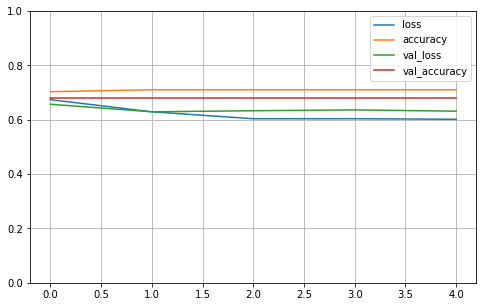

Compute valiation accuracy
2023-01-03 13:13:12.000998
Range of scores: 0.27786845 to 0.28609982
Predicted zeros and ones 112 0
Accuracy: 67.86% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:12.106832
Fold 4
Training example
[154 103 153 ...   0   0   0]
Train sizes (440, 3997) (440, 1)
Valid sizes (93, 3997) (93, 1)
Train set ones/size 140 / 440
Valid set ones/size 18 / 93
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:12.278158


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
14/14 [==============================] - 1s 23ms/step - loss: 0.6778 - accuracy: 0.6523 - val_loss: 0.6358 - val_accuracy: 0.8065
Epoch 2/5
14/14 [==============================] - 0s 11ms/step - loss: 0.6445 - accuracy: 0.6818 - val_loss: 0.5652 - val_accuracy: 0.8065
Epoch 3/5
14/14 [==============================] - 0s 11ms/step - loss: 0.6258 - accuracy: 0.6818 - val_loss: 0.5273 - val_accuracy: 0.8065
Epoch 4/5
14/14 [==============================] - 0s 10ms/step - loss: 0.6273 - accuracy: 0.6818 - val_loss: 0.5205 - val_accuracy: 0.8065
Epoch 5/5
14/14 [==============================] - 0s 9ms/step - loss: 0.6257 - accuracy: 0.6818 - val_loss: 0.5409 - val_accuracy: 0.8065


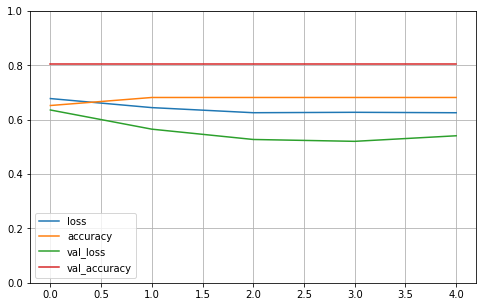

Compute valiation accuracy
2023-01-03 13:13:14.255825
Range of scores: 0.31987906 to 0.34574118
Predicted zeros and ones 93 0
Accuracy: 80.65% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:14.362327
Fold 5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[154 103 153 ...   0   0   0]
Train sizes (452, 3997) (452, 1)
Valid sizes (81, 3997) (81, 1)
Train set ones/size 131 / 452
Valid set ones/size 27 / 81
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:14.536346
Epoch 1/5
15/15 [==============================] - 1s 18ms/step - loss: 0.6737 - accuracy: 0.7102 - val_loss: 0.6595 - val_accuracy: 0.6667
Epoch 2/5
15/15 [==============================] - 0s 10ms/step - loss: 0.6312 - accuracy: 0.7102 - val_loss: 0.6371 - val_accuracy: 0.6667
Epoch 3/5
15/15 [==============================] - 0s 10ms/step - loss: 0.6049 - accuracy: 0.7102 - val_loss: 0.6444 - val_accuracy: 0.6667
Epoch 4/5
15/15 [==============================] - 0s 10ms/step - loss: 0.6032 - accuracy: 0.7102 - val_loss: 0.6443 - val_accuracy: 0.6667
Epoch 5/5
15/15 [==============================] - 0s 10ms/step - loss: 0.6021 - accuracy: 0.7102 - val_loss: 0.6418 - val_accuracy: 0.6667


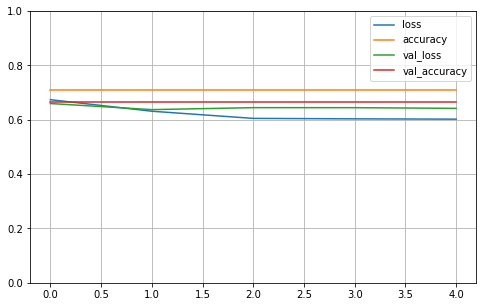

Compute valiation accuracy
2023-01-03 13:13:16.539746
Range of scores: 0.27585983 to 0.29518163
Predicted zeros and ones 81 0
Accuracy: 66.67% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:16.647694

Cross validation 5 folds 5 epochs
 accuracy mean 70.53% +/- 5.17
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:13:16.648403
-------------
2023-01-03 13:13:16.648463
Cell line for today: 6 = MCF.7
Load RCI values...
Num RCI: 2156
Load genes...
2023-01-03 13:13:16.669916
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:13:17.659729
Num IDs: 585
Count 148 ones out of 585 labels.
Num counts: 585
2023-01-03 13:13:17.660184
splitting
Fold 1
Training example
[154 103 153 ...   0   0   0]
Train sizes (470, 3997) (470, 1)
Valid sizes (115, 3997) (115, 1)
Train set ones/size 129 / 470
Valid set ones/size 19 / 115
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:17.854710
Epoch 1/5
15/15 [==============================] - 1s 23ms/step - loss: 0.6772 - accuracy: 0.6830 - val_loss: 0.6344 - val_accuracy: 0.8348
Epoch 2/5
15/15 [==============================] - 0s 11ms/step - loss: 0.6348 - accuracy: 0.7255 - val_loss: 0.5498 - val_accuracy: 0.8348
Epoch 3/5
15/15 [==============================] - 0s 11ms/step - loss: 0.5960 - accuracy: 0.7255 - val_loss: 0.4880 - val_accuracy: 0.8348
Epoch 4/5
15/15 [==============================] - 0s 11ms/step - loss: 0.5869 - accuracy: 0.7255 - val_loss: 0.4726 - val_accuracy: 0.8348
Epoch 5/5
15/15 [==============================] - 0s 11ms/step - loss: 0.5874 - ac

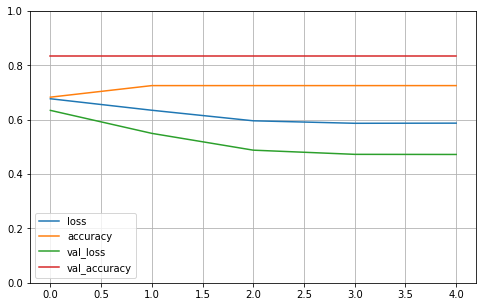

Compute valiation accuracy
2023-01-03 13:13:19.655553
Range of scores: 0.24584606 to 0.2753446
Predicted zeros and ones 115 0
Accuracy: 83.48% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:19.756778
Fold 2


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[154 103 153 ...   0   0   0]
Train sizes (448, 3997) (448, 1)
Valid sizes (137, 3997) (137, 1)
Train set ones/size 119 / 448
Valid set ones/size 29 / 137
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:19.942956
Epoch 1/5
14/14 [==============================] - 1s 19ms/step - loss: 0.6729 - accuracy: 0.7299 - val_loss: 0.6377 - val_accuracy: 0.7883
Epoch 2/5
14/14 [==============================] - 0s 10ms/step - loss: 0.6257 - accuracy: 0.7344 - val_loss: 0.5665 - val_accuracy: 0.7883
Epoch 3/5
14/14 [==============================] - 0s 10ms/step - loss: 0.5862 - accuracy: 0.7344 - val_loss: 0.5244 - val_accuracy: 0.7883
Epoch 4/5
14/14 [==============================] - 0s 11ms/step - loss: 0.5812 - accuracy: 0.7344 - val_loss: 0.5174 - val_accuracy: 0.7883
Epoch 5/5
14/14 [==============================] - 0s 10ms/step - loss: 0.5797 - accuracy: 0.7344 - val_loss: 0.5233 - val_accuracy: 0.7883


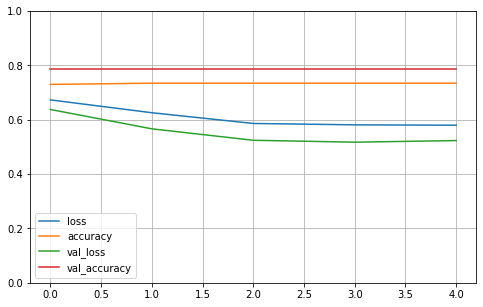

Compute valiation accuracy
2023-01-03 13:13:21.490042
Range of scores: 0.25385827 to 0.28667647
Predicted zeros and ones 137 0
Accuracy: 78.83% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:21.602755
Fold 3
Training example
[154 103 153 ...   0   0   0]
Train sizes (459, 3997) (459, 1)
Valid sizes (126, 3997) (126, 1)
Train set ones/size 109 / 459
Valid set ones/size 39 / 126
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:21.792321


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
15/15 [==============================] - 1s 19ms/step - loss: 0.6667 - accuracy: 0.7495 - val_loss: 0.6561 - val_accuracy: 0.6905
Epoch 2/5
15/15 [==============================] - 0s 10ms/step - loss: 0.6098 - accuracy: 0.7625 - val_loss: 0.6235 - val_accuracy: 0.6905
Epoch 3/5
15/15 [==============================] - 0s 11ms/step - loss: 0.5555 - accuracy: 0.7625 - val_loss: 0.6390 - val_accuracy: 0.6905
Epoch 4/5
15/15 [==============================] - 0s 11ms/step - loss: 0.5477 - accuracy: 0.7625 - val_loss: 0.6465 - val_accuracy: 0.6905
Epoch 5/5
15/15 [==============================] - 0s 10ms/step - loss: 0.5470 - accuracy: 0.7625 - val_loss: 0.6439 - val_accuracy: 0.6905


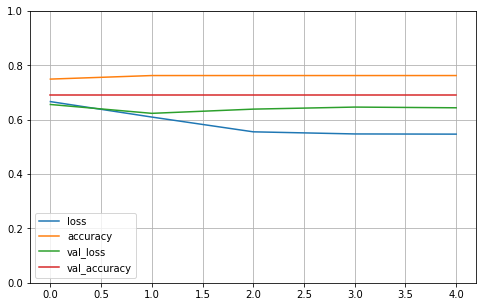

Compute valiation accuracy
2023-01-03 13:13:23.781614
Range of scores: 0.2066042 to 0.24372227
Predicted zeros and ones 126 0
Accuracy: 69.05% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:23.889681
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[171 172 174 ...   0   0   0]
Train sizes (481, 3997) (481, 1)
Valid sizes (104, 3997) (104, 1)
Train set ones/size 113 / 481
Valid set ones/size 35 / 104
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:24.097157
Epoch 1/5
16/16 [==============================] - 1s 26ms/step - loss: 0.6690 - accuracy: 0.7651 - val_loss: 0.6611 - val_accuracy: 0.6635
Epoch 2/5
16/16 [==============================] - 0s 11ms/step - loss: 0.6155 - accuracy: 0.7651 - val_loss: 0.6415 - val_accuracy: 0.6635
Epoch 3/5
16/16 [==============================] - 0s 11ms/step - loss: 0.5663 - accuracy: 0.7651 - val_loss: 0.6582 - val_accuracy: 0.6635
Epoch 4/5
16/16 [==============================] - 0s 10ms/step - loss: 0.5451 - accuracy: 0.7651 - val_loss: 0.6862 - val_accuracy: 0.6635
Epoch 5/5
16/16 [==============================] - 0s 10ms/step - loss: 0.5478 - accuracy: 0.7651 - val_loss: 0.6736 - val_accuracy: 0.6635


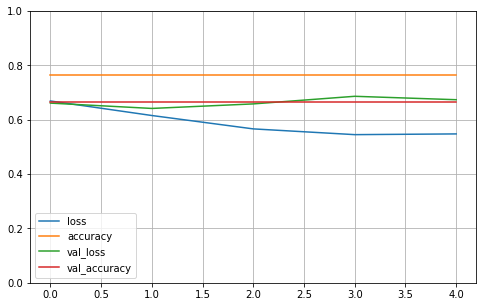

Compute valiation accuracy
2023-01-03 13:13:25.929605
Range of scores: 0.21429835 to 0.23743793
Predicted zeros and ones 104 0
Accuracy: 66.35% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:26.048324
Fold 5
Training example
[154 103 153 ...   0   0   0]
Train sizes (482, 3997) (482, 1)
Valid sizes (103, 3997) (103, 1)
Train set ones/size 122 / 482
Valid set ones/size 26 / 103
BUILD MODEL


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


COMPILE
FIT
2023-01-03 13:13:26.251759
Epoch 1/5
16/16 [==============================] - 1s 19ms/step - loss: 0.6680 - accuracy: 0.7178 - val_loss: 0.6344 - val_accuracy: 0.7476
Epoch 2/5
16/16 [==============================] - 0s 10ms/step - loss: 0.6031 - accuracy: 0.7469 - val_loss: 0.5742 - val_accuracy: 0.7476
Epoch 3/5
16/16 [==============================] - 0s 11ms/step - loss: 0.5675 - accuracy: 0.7469 - val_loss: 0.5651 - val_accuracy: 0.7476
Epoch 4/5
16/16 [==============================] - 0s 10ms/step - loss: 0.5701 - accuracy: 0.7469 - val_loss: 0.5644 - val_accuracy: 0.7476
Epoch 5/5
16/16 [==============================] - 0s 10ms/step - loss: 0.5653 - accuracy: 0.7469 - val_loss: 0.5645 - val_accuracy: 0.7476


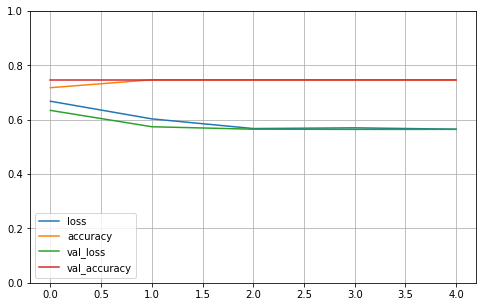

Compute valiation accuracy
2023-01-03 13:13:28.529110
Range of scores: 0.25636178 to 0.2823922
Predicted zeros and ones 103 0
Accuracy: 74.76% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:28.630537

Cross validation 5 folds 5 epochs
 accuracy mean 74.49% +/- 6.26
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:13:28.633760
-------------
2023-01-03 13:13:28.633818
Cell line for today: 7 = NCI.H460
Load RCI values...
Num RCI: 610
Load genes...
2023-01-03 13:13:28.644167
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:13:29.193718
Num IDs: 309
Count 84 ones out of 309 labels.
Num counts: 309
2023-01-03 13:13:29.201598
splitting
Fold 1
Training example
[154 103 153 ...   0   0   0]
Train sizes (238, 3997) (238, 1)
Valid sizes (71, 3997) (71, 1)
Train set ones/size 70 / 238
Valid set ones/size 14 / 71
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:29.326488
Epoch 1/5
8/8 [==============================] - 1s 38ms/step - loss: 0.6861 - accuracy: 0.6891 - val_loss: 0.6634 - val_accuracy: 0.8028
Epoch 2/5
8/8 [==============================] - 0s 14ms/step - loss: 0.6647 - accuracy: 0.7059 - val_loss: 0.6288 - val_accuracy: 0.8028
Epoch 3/5
8/8 [==============================] - 0s 13ms/step - loss: 0.6425 - accuracy: 0.7059 - val_loss: 0.5866 - val_accuracy: 0.8028
Epoch 4/5
8/8 [==============================] - 0s 13ms/step - loss: 0.6186 - accuracy: 0.7059 - val_loss: 0.5502 - val_accuracy: 0.8028
Epoch 5/5
8/8 [==============================] - 0s 13ms/step - loss: 0.6099 - accuracy: 0.7059 

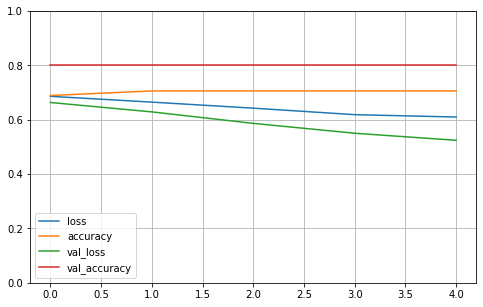

Compute valiation accuracy
2023-01-03 13:13:30.770286
Range of scores: 0.29745108 to 0.30550835
Predicted zeros and ones 71 0
Accuracy: 80.28% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:30.873658
Fold 2
Training example
[171 172 174 ...   0   0   0]
Train sizes (259, 3997) (259, 1)
Valid sizes (50, 3997) (50, 1)
Train set ones/size 73 / 259
Valid set ones/size 11 / 50
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:30.987191
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 1s 31ms/step - loss: 0.6850 - accuracy: 0.7143 - val_loss: 0.6639 - val_accuracy: 0.7800
Epoch 2/5
9/9 [==============================] - 0s 24ms/step - loss: 0.6605 - accuracy: 0.7181 - val_loss: 0.6271 - val_accuracy: 0.7800
Epoch 3/5
9/9 [==============================] - 0s 24ms/step - loss: 0.6339 - accuracy: 0.7181 - val_loss: 0.5854 - val_accuracy: 0.7800
Epoch 4/5
9/9 [==============================] - 0s 27ms/step - loss: 0.6085 - accuracy: 0.7181 - val_loss: 0.5530 - val_accuracy: 0.7800
Epoch 5/5
9/9 [==============================] - 0s 16ms/step - loss: 0.5962 - accuracy: 0.7181 - val_loss: 0.5447 - val_accuracy: 0.7800


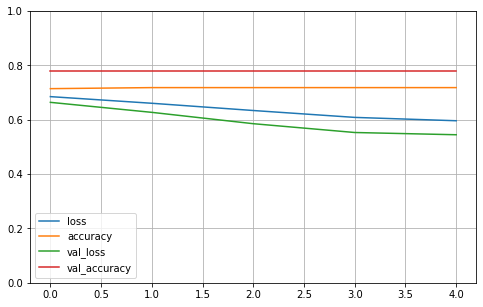

Compute valiation accuracy
2023-01-03 13:13:33.214147
Range of scores: 0.29490063 to 0.31604785
Predicted zeros and ones 50 0
Accuracy: 78.00% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:33.322473
Fold 3
Training example
[154 103 153 ...   0   0   0]
Train sizes (250, 3997) (250, 1)
Valid sizes (59, 3997) (59, 1)
Train set ones/size 71 / 250
Valid set ones/size 13 / 59
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:33.444587
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 31ms/step - loss: 0.6865 - accuracy: 0.6520 - val_loss: 0.6695 - val_accuracy: 0.7797
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.6670 - accuracy: 0.7160 - val_loss: 0.6411 - val_accuracy: 0.7797
Epoch 3/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6436 - accuracy: 0.7160 - val_loss: 0.6053 - val_accuracy: 0.7797
Epoch 4/5
8/8 [==============================] - 0s 14ms/step - loss: 0.6194 - accuracy: 0.7160 - val_loss: 0.5684 - val_accuracy: 0.7797
Epoch 5/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6025 - accuracy: 0.7160 - val_loss: 0.5421 - val_accuracy: 0.7797


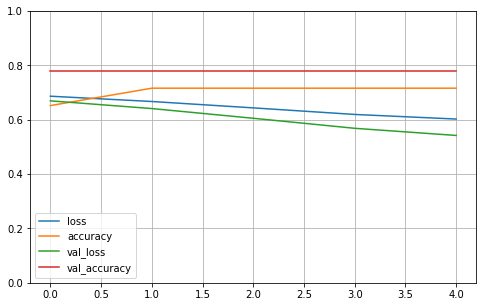

Compute valiation accuracy
2023-01-03 13:13:35.210550
Range of scores: 0.29079515 to 0.30649835
Predicted zeros and ones 59 0
Accuracy: 77.97% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:35.307591
Fold 4
Training example
[154 103 153 ...   0   0   0]
Train sizes (258, 3997) (258, 1)
Valid sizes (51, 3997) (51, 1)
Train set ones/size 62 / 258
Valid set ones/size 22 / 51
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:35.437232
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 1s 29ms/step - loss: 0.6833 - accuracy: 0.6977 - val_loss: 0.6871 - val_accuracy: 0.5686
Epoch 2/5
9/9 [==============================] - 0s 12ms/step - loss: 0.6529 - accuracy: 0.7597 - val_loss: 0.6835 - val_accuracy: 0.5686
Epoch 3/5
9/9 [==============================] - 0s 11ms/step - loss: 0.6218 - accuracy: 0.7597 - val_loss: 0.6880 - val_accuracy: 0.5686
Epoch 4/5
9/9 [==============================] - 0s 11ms/step - loss: 0.5844 - accuracy: 0.7597 - val_loss: 0.7062 - val_accuracy: 0.5686
Epoch 5/5
9/9 [==============================] - 0s 11ms/step - loss: 0.5577 - accuracy: 0.7597 - val_loss: 0.7402 - val_accuracy: 0.5686


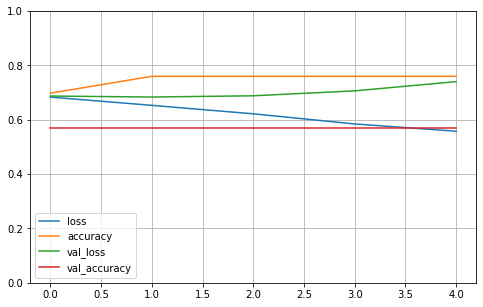

Compute valiation accuracy
2023-01-03 13:13:36.893734
Range of scores: 0.26620808 to 0.27835003
Predicted zeros and ones 51 0
Accuracy: 56.86% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:37.010833
Fold 5
Training example
[154 103 153 ...   0   0   0]
Train sizes (231, 3997) (231, 1)
Valid sizes (78, 3997) (78, 1)
Train set ones/size 60 / 231
Valid set ones/size 24 / 78
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:37.135298
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 31ms/step - loss: 0.6838 - accuracy: 0.7403 - val_loss: 0.6740 - val_accuracy: 0.6923
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.6596 - accuracy: 0.7403 - val_loss: 0.6519 - val_accuracy: 0.6923
Epoch 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.6269 - accuracy: 0.7403 - val_loss: 0.6311 - val_accuracy: 0.6923
Epoch 4/5
8/8 [==============================] - 0s 12ms/step - loss: 0.5978 - accuracy: 0.7403 - val_loss: 0.6180 - val_accuracy: 0.6923
Epoch 5/5
8/8 [==============================] - 0s 12ms/step - loss: 0.5814 - accuracy: 0.7403 - val_loss: 0.6181 - val_accuracy: 0.6923


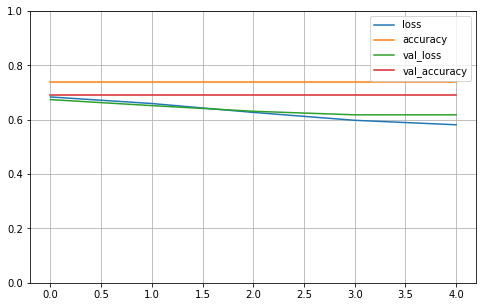

Compute valiation accuracy
2023-01-03 13:13:38.586678
Range of scores: 0.27948132 to 0.28785238
Predicted zeros and ones 78 0
Accuracy: 69.23% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:38.694472

Cross validation 5 folds 5 epochs
 accuracy mean 72.47% +/- 8.67
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:13:38.698062
-------------
2023-01-03 13:13:38.698140
Cell line for today: 8 = NHEK
Load RCI values...
Num RCI: 1080
Load genes...
2023-01-03 13:13:38.707638
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:13:39.494379
Num IDs: 458
Count 156 ones out of 458 labels.
Num counts: 458
2023-01-03 13:13:39.494805
splitting
Fold 1
Training example
[154 103 153 ...   0   0   0]
Train sizes (369, 3997) (369, 1)
Valid sizes (89, 3997) (89, 1)
Train set ones/size 114 / 369
Valid set ones/size 42 / 89
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:39.653637
Epoch 1/5
12/12 [==============================] - 1s 25ms/step - loss: 0.6844 - accuracy: 0.6585 - val_loss: 0.6917 - val_accuracy: 0.5281
Epoch 2/5
12/12 [==============================] - 0s 11ms/step - loss: 0.6583 - accuracy: 0.6911 - val_loss: 0.6984 - val_accuracy: 0.5281
Epoch 3/5
12/12 [==============================] - 0s 10ms/step - loss: 0.6309 - accuracy: 0.6911 - val_loss: 0.7270 - val_accuracy: 0.5281
Epoch 4/5
12/12 [==============================] - 0s 11ms/step - loss: 0.6207 - accuracy: 0.6911 - val_loss: 0.7645 - val_accuracy: 0.5281
Epoch 5/5
12/12 [==============================] - 0s 12ms/step - loss: 0.6179 - accur

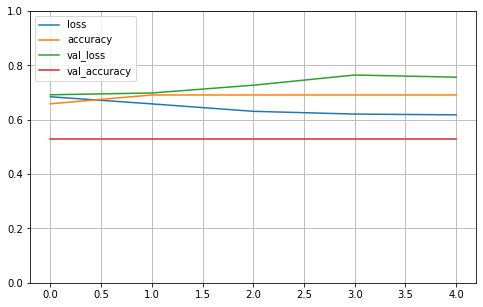

Compute valiation accuracy
2023-01-03 13:13:41.638197
Range of scores: 0.28714523 to 0.30621645
Predicted zeros and ones 89 0
Accuracy: 52.81% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:41.747025
Fold 2
Training example
[171 172 174 ...   0   0   0]
Train sizes (364, 3997) (364, 1)
Valid sizes (94, 3997) (94, 1)
Train set ones/size 128 / 364
Valid set ones/size 28 / 94
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:41.894551
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/12 [==============================] - 1s 25ms/step - loss: 0.6860 - accuracy: 0.6236 - val_loss: 0.6676 - val_accuracy: 0.7021
Epoch 2/5
12/12 [==============================] - 0s 11ms/step - loss: 0.6684 - accuracy: 0.6484 - val_loss: 0.6432 - val_accuracy: 0.7021
Epoch 3/5
12/12 [==============================] - 0s 10ms/step - loss: 0.6535 - accuracy: 0.6484 - val_loss: 0.6212 - val_accuracy: 0.7021
Epoch 4/5
12/12 [==============================] - 0s 10ms/step - loss: 0.6497 - accuracy: 0.6484 - val_loss: 0.6116 - val_accuracy: 0.7021
Epoch 5/5
12/12 [==============================] - 0s 10ms/step - loss: 0.6481 - accuracy: 0.6484 - val_loss: 0.6126 - val_accuracy: 0.7021


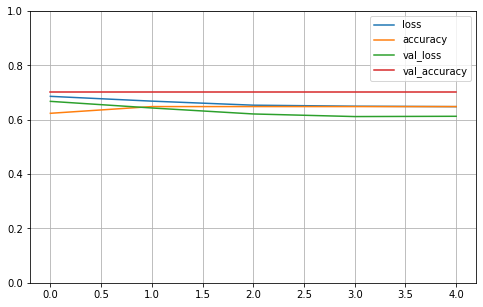

Compute valiation accuracy
2023-01-03 13:13:44.148419
Range of scores: 0.33441457 to 0.35061735
Predicted zeros and ones 94 0
Accuracy: 70.21% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:44.245837
Fold 3
Training example
[154 103 153 ...   0   0   0]
Train sizes (371, 3997) (371, 1)
Valid sizes (87, 3997) (87, 1)
Train set ones/size 121 / 371
Valid set ones/size 35 / 87
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:44.395035
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


12/12 [==============================] - 1s 23ms/step - loss: 0.6820 - accuracy: 0.6739 - val_loss: 0.6798 - val_accuracy: 0.5977
Epoch 2/5
12/12 [==============================] - 0s 10ms/step - loss: 0.6555 - accuracy: 0.6739 - val_loss: 0.6735 - val_accuracy: 0.5977
Epoch 3/5
12/12 [==============================] - 0s 12ms/step - loss: 0.6312 - accuracy: 0.6739 - val_loss: 0.6846 - val_accuracy: 0.5977
Epoch 4/5
12/12 [==============================] - 0s 11ms/step - loss: 0.6353 - accuracy: 0.6739 - val_loss: 0.6983 - val_accuracy: 0.5977
Epoch 5/5
12/12 [==============================] - 0s 10ms/step - loss: 0.6307 - accuracy: 0.6739 - val_loss: 0.6835 - val_accuracy: 0.5977


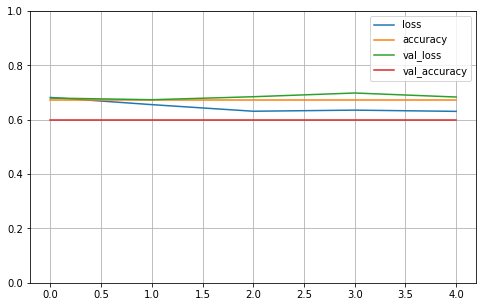

Compute valiation accuracy
2023-01-03 13:13:45.961139
Range of scores: 0.31361523 to 0.33511576
Predicted zeros and ones 87 0
Accuracy: 59.77% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:46.073973
Fold 4
Training example
[154 103 153 ...   0   0   0]
Train sizes (395, 3997) (395, 1)
Valid sizes (63, 3997) (63, 1)
Train set ones/size 137 / 395
Valid set ones/size 19 / 63
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:46.228643


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
13/13 [==============================] - 1s 20ms/step - loss: 0.6827 - accuracy: 0.6532 - val_loss: 0.6621 - val_accuracy: 0.6984
Epoch 2/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6614 - accuracy: 0.6532 - val_loss: 0.6309 - val_accuracy: 0.6984
Epoch 3/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6480 - accuracy: 0.6532 - val_loss: 0.6166 - val_accuracy: 0.6984
Epoch 4/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6442 - accuracy: 0.6532 - val_loss: 0.6135 - val_accuracy: 0.6984
Epoch 5/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6430 - accuracy: 0.6532 - val_loss: 0.6165 - val_accuracy: 0.6984


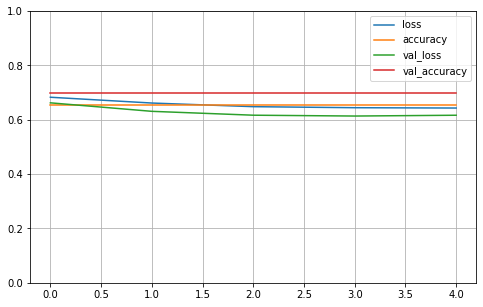

Compute valiation accuracy
2023-01-03 13:13:48.216508
Range of scores: 0.33440575 to 0.37596008
Predicted zeros and ones 63 0
Accuracy: 69.84% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:48.332127
Fold 5
Training example
[154 103 153 ...   0   0   0]
Train sizes (333, 3997) (333, 1)
Valid sizes (125, 3997) (125, 1)
Train set ones/size 124 / 333
Valid set ones/size 32 / 125
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:48.482867
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11/11 [==============================] - 1s 30ms/step - loss: 0.6853 - accuracy: 0.6276 - val_loss: 0.6582 - val_accuracy: 0.7440
Epoch 2/5
11/11 [==============================] - 0s 12ms/step - loss: 0.6708 - accuracy: 0.6276 - val_loss: 0.6229 - val_accuracy: 0.7440
Epoch 3/5
11/11 [==============================] - 0s 13ms/step - loss: 0.6619 - accuracy: 0.6276 - val_loss: 0.6033 - val_accuracy: 0.7440
Epoch 4/5
11/11 [==============================] - 0s 11ms/step - loss: 0.6580 - accuracy: 0.6276 - val_loss: 0.5986 - val_accuracy: 0.7440
Epoch 5/5
11/11 [==============================] - 0s 11ms/step - loss: 0.6578 - accuracy: 0.6276 - val_loss: 0.5961 - val_accuracy: 0.7440


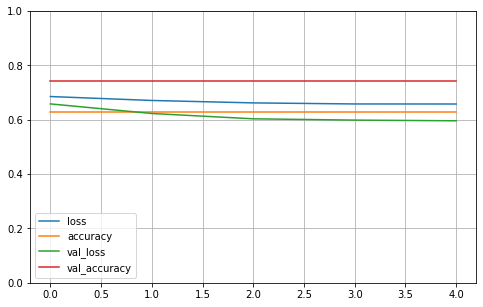

Compute valiation accuracy
2023-01-03 13:13:50.465381
Range of scores: 0.3421878 to 0.38242322
Predicted zeros and ones 125 0
Accuracy: 74.40% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:50.565254

Cross validation 5 folds 5 epochs
 accuracy mean 65.41% +/- 7.93
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:13:50.565885
-------------
2023-01-03 13:13:50.565941
Cell line for today: 9 = SK.MEL.5
Load RCI values...
Num RCI: 534
Load genes...
2023-01-03 13:13:50.576991
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:13:51.147772
Num IDs: 300
Count 65 ones out of 300 labels.
Num counts: 300
2023-01-03 13:13:51.148173
splitting
Fold 1
Training example
[154 103 153 ...   0   0   0]
Train sizes (237, 3997) (237, 1)
Valid sizes (63, 3997) (63, 1)
Train set ones/size 53 / 237
Valid set ones/size 12 / 63
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:51.271304
Epoch 1/5
8/8 [==============================] - 1s 30ms/step - loss: 0.6788 - accuracy: 0.7764 - val_loss: 0.6538 - val_accuracy: 0.8095
Epoch 2/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6427 - accuracy: 0.7764 - val_loss: 0.6063 - val_accuracy: 0.8095
Epoch 3/5
8/8 [==============================] - 0s 13ms/step - loss: 0.5986 - accuracy: 0.7764 - val_loss: 0.5562 - val_accuracy: 0.8095
Epoch 4/5
8/8 [==============================] - 0s 12ms/step - loss: 0.5623 - accuracy: 0.7764 - val_loss: 0.5147 - val_accuracy: 0.8095
Epoch 5/5
8/8 [==============================] - 0s 12ms/step - loss: 0.5370 - accuracy: 0.7764 

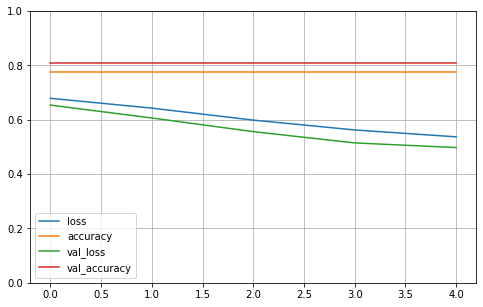

Compute valiation accuracy
2023-01-03 13:13:52.680132
Range of scores: 0.23726687 to 0.25564545
Predicted zeros and ones 63 0
Accuracy: 80.95% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:52.782357
Fold 2
Training example
[154 103 153 ...   0   0   0]
Train sizes (238, 3997) (238, 1)
Valid sizes (62, 3997) (62, 1)
Train set ones/size 51 / 238
Valid set ones/size 14 / 62
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:52.898269
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 31ms/step - loss: 0.6816 - accuracy: 0.7857 - val_loss: 0.6668 - val_accuracy: 0.7742
Epoch 2/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6517 - accuracy: 0.7857 - val_loss: 0.6333 - val_accuracy: 0.7742
Epoch 3/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6126 - accuracy: 0.7857 - val_loss: 0.5959 - val_accuracy: 0.7742
Epoch 4/5
8/8 [==============================] - 0s 12ms/step - loss: 0.5711 - accuracy: 0.7857 - val_loss: 0.5614 - val_accuracy: 0.7742
Epoch 5/5
8/8 [==============================] - 0s 13ms/step - loss: 0.5389 - accuracy: 0.7857 - val_loss: 0.5404 - val_accuracy: 0.7742


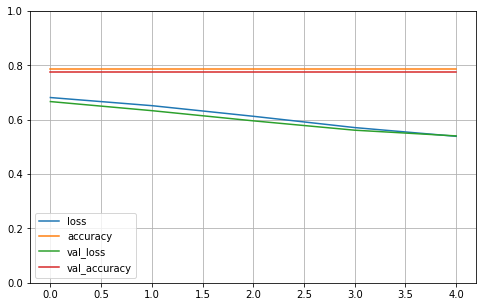

Compute valiation accuracy
2023-01-03 13:13:54.862586
Range of scores: 0.25190213 to 0.27421692
Predicted zeros and ones 62 0
Accuracy: 77.42% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:54.965273
Fold 3
Training example
[154 103 153 ...   0   0   0]
Train sizes (256, 3997) (256, 1)
Valid sizes (44, 3997) (44, 1)
Train set ones/size 54 / 256
Valid set ones/size 11 / 44
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:55.084350
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 33ms/step - loss: 0.6821 - accuracy: 0.7891 - val_loss: 0.6701 - val_accuracy: 0.7500
Epoch 2/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6512 - accuracy: 0.7891 - val_loss: 0.6426 - val_accuracy: 0.7500
Epoch 3/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6166 - accuracy: 0.7891 - val_loss: 0.6100 - val_accuracy: 0.7500
Epoch 4/5
8/8 [==============================] - 0s 12ms/step - loss: 0.5769 - accuracy: 0.7891 - val_loss: 0.5795 - val_accuracy: 0.7500
Epoch 5/5
8/8 [==============================] - 0s 12ms/step - loss: 0.5403 - accuracy: 0.7891 - val_loss: 0.5631 - val_accuracy: 0.7500


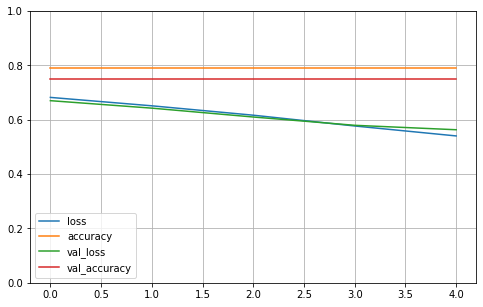

Compute valiation accuracy
2023-01-03 13:13:56.378318
Range of scores: 0.26850775 to 0.27741802
Predicted zeros and ones 44 0
Accuracy: 75.00% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:56.475440
Fold 4
Training example
[154 103 153 ...   0   0   0]
Train sizes (228, 3997) (228, 1)
Valid sizes (72, 3997) (72, 1)
Train set ones/size 46 / 228
Valid set ones/size 19 / 72
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:56.598877
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 31ms/step - loss: 0.6821 - accuracy: 0.7895 - val_loss: 0.6670 - val_accuracy: 0.7361
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.6463 - accuracy: 0.7982 - val_loss: 0.6361 - val_accuracy: 0.7361
Epoch 3/5
8/8 [==============================] - 0s 10ms/step - loss: 0.5998 - accuracy: 0.7982 - val_loss: 0.6036 - val_accuracy: 0.7361
Epoch 4/5
8/8 [==============================] - 0s 13ms/step - loss: 0.5587 - accuracy: 0.7982 - val_loss: 0.5801 - val_accuracy: 0.7361
Epoch 5/5
8/8 [==============================] - 0s 13ms/step - loss: 0.5205 - accuracy: 0.7982 - val_loss: 0.5775 - val_accuracy: 0.7361


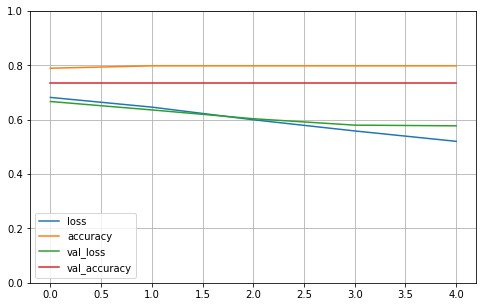

Compute valiation accuracy
2023-01-03 13:13:58.574916
Range of scores: 0.23266402 to 0.24877827
Predicted zeros and ones 72 0
Accuracy: 73.61% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:13:58.681226
Fold 5
Training example
[171 172 174 ...   0   0   0]
Train sizes (241, 3997) (241, 1)
Valid sizes (59, 3997) (59, 1)
Train set ones/size 56 / 241
Valid set ones/size 9 / 59
BUILD MODEL
COMPILE
FIT
2023-01-03 13:13:58.798327
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 32ms/step - loss: 0.6816 - accuracy: 0.7676 - val_loss: 0.6548 - val_accuracy: 0.8475
Epoch 2/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6490 - accuracy: 0.7676 - val_loss: 0.6069 - val_accuracy: 0.8475
Epoch 3/5
8/8 [==============================] - 0s 11ms/step - loss: 0.6130 - accuracy: 0.7676 - val_loss: 0.5491 - val_accuracy: 0.8475
Epoch 4/5
8/8 [==============================] - 0s 14ms/step - loss: 0.5745 - accuracy: 0.7676 - val_loss: 0.4939 - val_accuracy: 0.8475
Epoch 5/5
8/8 [==============================] - 0s 14ms/step - loss: 0.5492 - accuracy: 0.7676 - val_loss: 0.4553 - val_accuracy: 0.8475


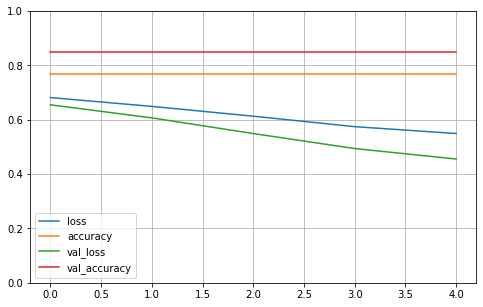

Compute valiation accuracy
2023-01-03 13:14:01.033469
Range of scores: 0.2470746 to 0.25189582
Predicted zeros and ones 59 0
Accuracy: 84.75% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:01.142333

Cross validation 5 folds 5 epochs
 accuracy mean 78.35% +/- 4.06
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:14:01.142996
-------------
2023-01-03 13:14:01.143052
Cell line for today: 10 = SK.N.DZ
Load RCI values...
Num RCI: 603
Load genes...
2023-01-03 13:14:01.157731
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:14:01.810919
Num IDs: 375
Count 159 ones out of 375 labels.
Num counts: 375
2023-01-03 13:14:01.811686
splitting
Fold 1
Training example
[171 172 174 ...   0   0   0]
Train sizes (305, 3997) (305, 1)
Valid sizes (70, 3997) (70, 1)
Train set ones/size 111 / 305
Valid set ones/size 48 / 70
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:01.952764
Epoch 1/5
10/10 [==============================] - 1s 27ms/step - loss: 0.6875 - accuracy: 0.6066 - val_loss: 0.7156 - val_accuracy: 0.3143
Epoch 2/5
10/10 [==============================] - 0s 12ms/step - loss: 0.6737 - accuracy: 0.6361 - val_loss: 0.7541 - val_accuracy: 0.3143
Epoch 3/5
10/10 [==============================] - 0s 12ms/step - loss: 0.6610 - accuracy: 0.6361 - val_loss: 0.8126 - val_accuracy: 0.3143
Epoch 4/5
10/10 [==============================] - 0s 11ms/step - loss: 0.6550 - accuracy: 0.6361 - val_loss: 0.8388 - val_accuracy: 0.3143
Epoch 5/5
10/10 [==============================] - 0s 12ms/step - loss: 0.6555 - accur

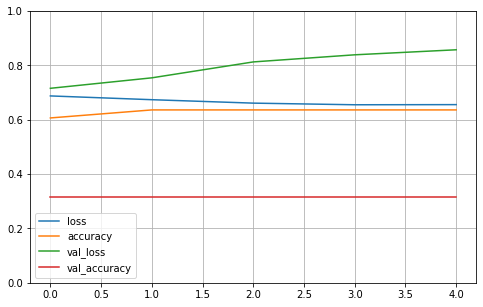

Compute valiation accuracy
2023-01-03 13:14:03.445010
Range of scores: 0.34552002 to 0.35186112
Predicted zeros and ones 70 0
Accuracy: 31.43% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:03.549654
Fold 2
Training example
[171 172 174 ...   0   0   0]
Train sizes (300, 3997) (300, 1)
Valid sizes (75, 3997) (75, 1)
Train set ones/size 133 / 300
Valid set ones/size 26 / 75
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:03.686086
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 1s 27ms/step - loss: 0.6915 - accuracy: 0.5367 - val_loss: 0.6830 - val_accuracy: 0.6533
Epoch 2/5
10/10 [==============================] - 0s 12ms/step - loss: 0.6888 - accuracy: 0.5567 - val_loss: 0.6781 - val_accuracy: 0.6533
Epoch 3/5
10/10 [==============================] - 0s 13ms/step - loss: 0.6873 - accuracy: 0.5567 - val_loss: 0.6693 - val_accuracy: 0.6533
Epoch 4/5
10/10 [==============================] - 0s 11ms/step - loss: 0.6862 - accuracy: 0.5567 - val_loss: 0.6645 - val_accuracy: 0.6533
Epoch 5/5
10/10 [==============================] - 0s 12ms/step - loss: 0.6855 - accuracy: 0.5567 - val_loss: 0.6655 - val_accuracy: 0.6533


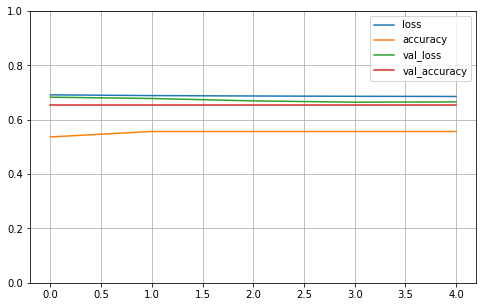

Compute valiation accuracy
2023-01-03 13:14:05.181827
Range of scores: 0.4328318 to 0.4511842
Predicted zeros and ones 75 0
Accuracy: 65.33% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:05.295331
Fold 3
Training example
[186 232 158 ...   0   0   0]
Train sizes (290, 3997) (290, 1)
Valid sizes (85, 3997) (85, 1)
Train set ones/size 129 / 290
Valid set ones/size 30 / 85
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:05.431781
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 1s 25ms/step - loss: 0.6919 - accuracy: 0.5414 - val_loss: 0.6835 - val_accuracy: 0.6471
Epoch 2/5
10/10 [==============================] - 0s 12ms/step - loss: 0.6888 - accuracy: 0.5552 - val_loss: 0.6755 - val_accuracy: 0.6471
Epoch 3/5
10/10 [==============================] - 0s 11ms/step - loss: 0.6877 - accuracy: 0.5552 - val_loss: 0.6694 - val_accuracy: 0.6471
Epoch 4/5
10/10 [==============================] - 0s 11ms/step - loss: 0.6872 - accuracy: 0.5552 - val_loss: 0.6644 - val_accuracy: 0.6471
Epoch 5/5
10/10 [==============================] - 0s 13ms/step - loss: 0.6866 - accuracy: 0.5552 - val_loss: 0.6689 - val_accuracy: 0.6471


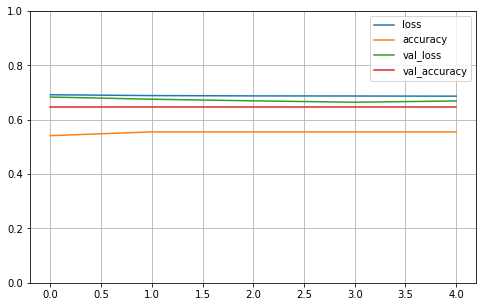

Compute valiation accuracy
2023-01-03 13:14:07.387210
Range of scores: 0.44804153 to 0.45233843
Predicted zeros and ones 85 0
Accuracy: 64.71% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:07.499016
Fold 4
Training example
[171 172 174 ...   0   0   0]
Train sizes (296, 3997) (296, 1)
Valid sizes (79, 3997) (79, 1)
Train set ones/size 125 / 296
Valid set ones/size 34 / 79
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:07.644524
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 1s 27ms/step - loss: 0.6924 - accuracy: 0.5372 - val_loss: 0.6895 - val_accuracy: 0.5696
Epoch 2/5
10/10 [==============================] - 0s 12ms/step - loss: 0.6867 - accuracy: 0.5777 - val_loss: 0.6856 - val_accuracy: 0.5696
Epoch 3/5
10/10 [==============================] - 0s 11ms/step - loss: 0.6829 - accuracy: 0.5777 - val_loss: 0.6841 - val_accuracy: 0.5696
Epoch 4/5
10/10 [==============================] - 0s 12ms/step - loss: 0.6810 - accuracy: 0.5777 - val_loss: 0.6837 - val_accuracy: 0.5696
Epoch 5/5
10/10 [==============================] - 0s 11ms/step - loss: 0.6817 - accuracy: 0.5777 - val_loss: 0.6844 - val_accuracy: 0.5696


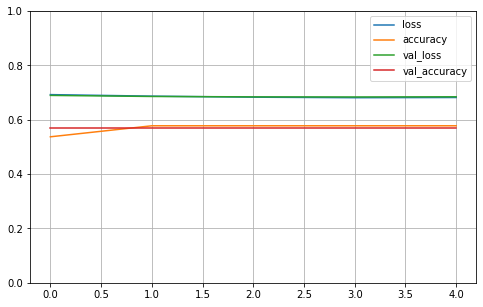

Compute valiation accuracy
2023-01-03 13:14:09.618751
Range of scores: 0.4071643 to 0.4170843
Predicted zeros and ones 79 0
Accuracy: 56.96% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:09.717729
Fold 5
Training example
[171 172 174 ...   0   0   0]
Train sizes (309, 3997) (309, 1)
Valid sizes (66, 3997) (66, 1)
Train set ones/size 138 / 309
Valid set ones/size 21 / 66
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:09.853964
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 1s 28ms/step - loss: 0.6942 - accuracy: 0.4498 - val_loss: 0.6932 - val_accuracy: 0.4394
Epoch 2/5
10/10 [==============================] - 0s 11ms/step - loss: 0.6916 - accuracy: 0.5502 - val_loss: 0.6847 - val_accuracy: 0.6818
Epoch 3/5
10/10 [==============================] - 0s 12ms/step - loss: 0.6901 - accuracy: 0.5534 - val_loss: 0.6750 - val_accuracy: 0.6818
Epoch 4/5
10/10 [==============================] - 0s 12ms/step - loss: 0.6879 - accuracy: 0.5534 - val_loss: 0.6696 - val_accuracy: 0.6818
Epoch 5/5
10/10 [==============================] - 0s 12ms/step - loss: 0.6870 - accuracy: 0.5534 - val_loss: 0.6631 - val_accuracy: 0.6818


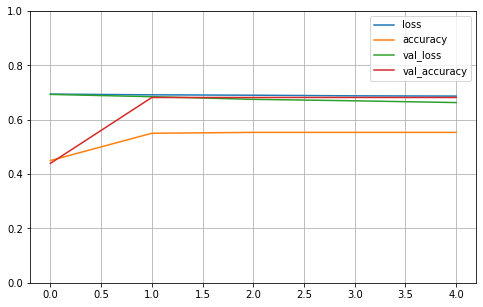

Compute valiation accuracy
2023-01-03 13:14:11.340867
Range of scores: 0.44382334 to 0.45434755
Predicted zeros and ones 66 0
Accuracy: 68.18% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:11.441240

Cross validation 5 folds 5 epochs
 accuracy mean 57.32% +/- 13.47
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:14:11.441924
-------------
2023-01-03 13:14:11.441980
Cell line for today: 11 = SK.N.SH
Load RCI values...
Num RCI: 1647
Load genes...
2023-01-03 13:14:11.458549
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:14:12.390662
Num IDs: 561
Count 188 ones out of 561 labels.
Num counts: 561
2023-01-03 13:14:12.391118
splitting
Fold 1
Training example
[154 103 153 ...   0   0   0]
Train sizes (434, 3997) (434, 1)
Valid sizes (127, 3997) (127, 1)
Train set ones/size 147 / 434
Valid set ones/size 41 / 127
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:12.579260
Epoch 1/5
14/14 [==============================] - 1s 21ms/step - loss: 0.6815 - accuracy: 0.6613 - val_loss: 0.6641 - val_accuracy: 0.6772
Epoch 2/5
14/14 [==============================] - 0s 11ms/step - loss: 0.6554 - accuracy: 0.6613 - val_loss: 0.6352 - val_accuracy: 0.6772
Epoch 3/5
14/14 [==============================] - 0s 10ms/step - loss: 0.6387 - accuracy: 0.6613 - val_loss: 0.6275 - val_accuracy: 0.6772
Epoch 4/5
14/14 [==============================] - 0s 10ms/step - loss: 0.6386 - accuracy: 0.6613 - val_loss: 0.6259 - val_accuracy: 0.6772
Epoch 5/5
14/14 [==============================] - 0s 10ms/step - loss: 0.6367 - ac

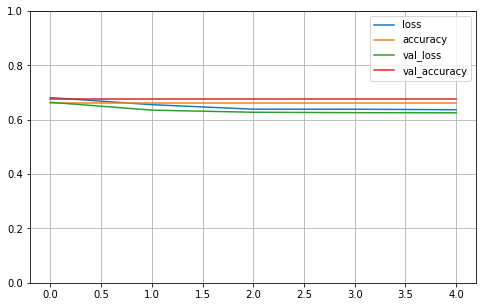

Compute valiation accuracy
2023-01-03 13:14:14.259956
Range of scores: 0.31421685 to 0.36038783
Predicted zeros and ones 127 0
Accuracy: 67.72% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:14.365010
Fold 2
Training example
[154 103 153 ...   0   0   0]
Train sizes (422, 3997) (422, 1)
Valid sizes (139, 3997) (139, 1)
Train set ones/size 137 / 422
Valid set ones/size 51 / 139
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:14.550630


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
14/14 [==============================] - 1s 20ms/step - loss: 0.6797 - accuracy: 0.6445 - val_loss: 0.6697 - val_accuracy: 0.6331
Epoch 2/5
14/14 [==============================] - 0s 10ms/step - loss: 0.6491 - accuracy: 0.6754 - val_loss: 0.6563 - val_accuracy: 0.6331
Epoch 3/5
14/14 [==============================] - 0s 10ms/step - loss: 0.6308 - accuracy: 0.6754 - val_loss: 0.6636 - val_accuracy: 0.6331
Epoch 4/5
14/14 [==============================] - 0s 10ms/step - loss: 0.6315 - accuracy: 0.6754 - val_loss: 0.6626 - val_accuracy: 0.6331
Epoch 5/5
14/14 [==============================] - 0s 12ms/step - loss: 0.6277 - accuracy: 0.6754 - val_loss: 0.6545 - val_accuracy: 0.6331


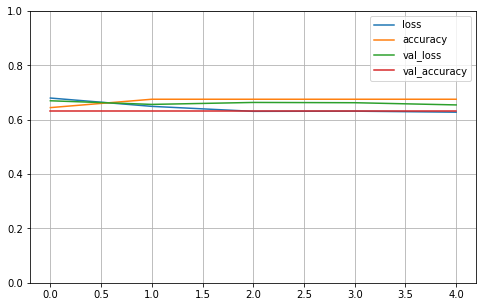

Compute valiation accuracy
2023-01-03 13:14:16.511332
Range of scores: 0.32428044 to 0.34797838
Predicted zeros and ones 139 0
Accuracy: 63.31% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:16.630200
Fold 3


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[154 103 153 ...   0   0   0]
Train sizes (466, 3997) (466, 1)
Valid sizes (95, 3997) (95, 1)
Train set ones/size 166 / 466
Valid set ones/size 22 / 95
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:16.809542
Epoch 1/5
15/15 [==============================] - 1s 18ms/step - loss: 0.6858 - accuracy: 0.6373 - val_loss: 0.6613 - val_accuracy: 0.7684
Epoch 2/5
15/15 [==============================] - 0s 10ms/step - loss: 0.6655 - accuracy: 0.6438 - val_loss: 0.6075 - val_accuracy: 0.7684
Epoch 3/5
15/15 [==============================] - 0s 11ms/step - loss: 0.6494 - accuracy: 0.6438 - val_loss: 0.5729 - val_accuracy: 0.7684
Epoch 4/5
15/15 [==============================] - 0s 10ms/step - loss: 0.6478 - accuracy: 0.6438 - val_loss: 0.5699 - val_accuracy: 0.7684
Epoch 5/5
15/15 [==============================] - 0s 11ms/step - loss: 0.6456 - accuracy: 0.6438 - val_loss: 0.5706 - val_accuracy: 0.7684


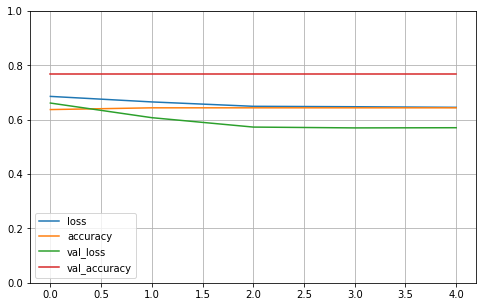

Compute valiation accuracy
2023-01-03 13:14:18.786813
Range of scores: 0.31540447 to 0.37746567
Predicted zeros and ones 95 0
Accuracy: 76.84% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:18.885269
Fold 4


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training example
[154 103 153 ...   0   0   0]
Train sizes (467, 3997) (467, 1)
Valid sizes (94, 3997) (94, 1)
Train set ones/size 149 / 467
Valid set ones/size 39 / 94
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:19.069621
Epoch 1/5
15/15 [==============================] - 1s 19ms/step - loss: 0.6775 - accuracy: 0.6595 - val_loss: 0.6802 - val_accuracy: 0.5851
Epoch 2/5
15/15 [==============================] - 0s 11ms/step - loss: 0.6453 - accuracy: 0.6809 - val_loss: 0.6827 - val_accuracy: 0.5851
Epoch 3/5
15/15 [==============================] - 0s 12ms/step - loss: 0.6249 - accuracy: 0.6809 - val_loss: 0.7002 - val_accuracy: 0.5851
Epoch 4/5
15/15 [==============================] - 0s 12ms/step - loss: 0.6236 - accuracy: 0.6809 - val_loss: 0.7003 - val_accuracy: 0.5851
Epoch 5/5
15/15 [==============================] - 0s 11ms/step - loss: 0.6214 - accuracy: 0.6809 - val_loss: 0.6951 - val_accuracy: 0.5851


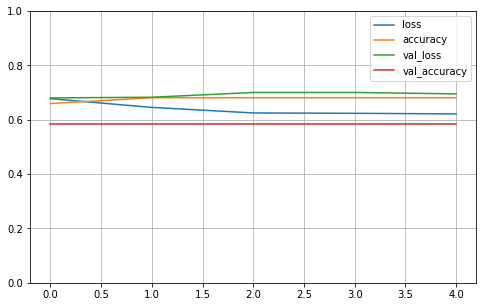

Compute valiation accuracy
2023-01-03 13:14:20.836501
Range of scores: 0.28642786 to 0.33618972
Predicted zeros and ones 94 0
Accuracy: 58.51% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:20.946456
Fold 5
Training example
[171 172 174 ...   0   0   0]
Train sizes (455, 3997) (455, 1)
Valid sizes (106, 3997) (106, 1)
Train set ones/size 153 / 455
Valid set ones/size 35 / 106
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:21.130168


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
15/15 [==============================] - 1s 20ms/step - loss: 0.6799 - accuracy: 0.6637 - val_loss: 0.6610 - val_accuracy: 0.6698
Epoch 2/5
15/15 [==============================] - 0s 12ms/step - loss: 0.6491 - accuracy: 0.6637 - val_loss: 0.6367 - val_accuracy: 0.6698
Epoch 3/5
15/15 [==============================] - 0s 12ms/step - loss: 0.6371 - accuracy: 0.6637 - val_loss: 0.6343 - val_accuracy: 0.6698
Epoch 4/5
15/15 [==============================] - 0s 11ms/step - loss: 0.6359 - accuracy: 0.6637 - val_loss: 0.6337 - val_accuracy: 0.6698
Epoch 5/5
15/15 [==============================] - 0s 12ms/step - loss: 0.6339 - accuracy: 0.6637 - val_loss: 0.6331 - val_accuracy: 0.6698


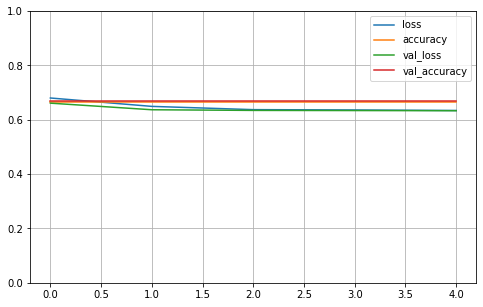

Compute valiation accuracy
2023-01-03 13:14:22.898697
Range of scores: 0.3112539 to 0.3552523
Predicted zeros and ones 106 0
Accuracy: 66.98% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:23.015022

Cross validation 5 folds 5 epochs
 accuracy mean 66.67% +/- 6.04
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:14:23.015720
-------------
2023-01-03 13:14:23.015779
Cell line for today: 12 = GM12878
Load RCI values...
Num RCI: 1698
Load genes...
2023-01-03 13:14:23.029214
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:14:23.879118
Num IDs: 484
Count 131 ones out of 484 labels.
Num counts: 484
2023-01-03 13:14:23.881539
splitting
Fold 1
Training example
[154 103 153 ...   0   0   0]
Train sizes (396, 3997) (396, 1)
Valid sizes (88, 3997) (88, 1)
Train set ones/size 112 / 396
Valid set ones/size 19 / 88
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:24.038831
Epoch 1/5
13/13 [==============================] - 1s 21ms/step - loss: 0.6763 - accuracy: 0.7121 - val_loss: 0.6381 - val_accuracy: 0.7841
Epoch 2/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6311 - accuracy: 0.7172 - val_loss: 0.5716 - val_accuracy: 0.7841
Epoch 3/5
13/13 [==============================] - 0s 11ms/step - loss: 0.5997 - accuracy: 0.7172 - val_loss: 0.5329 - val_accuracy: 0.7841
Epoch 4/5
13/13 [==============================] - 0s 11ms/step - loss: 0.5958 - accuracy: 0.7172 - val_loss: 0.5267 - val_accuracy: 0.7841
Epoch 5/5
13/13 [==============================] - 0s 10ms/step - loss: 0.5966 - accur

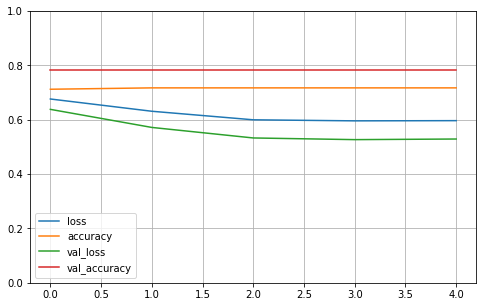

Compute valiation accuracy
2023-01-03 13:14:25.646231
Range of scores: 0.2601404 to 0.2857756
Predicted zeros and ones 88 0
Accuracy: 78.41% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:25.762384
Fold 2
Training example
[154 103 153 ...   0   0   0]
Train sizes (392, 3997) (392, 1)
Valid sizes (92, 3997) (92, 1)
Train set ones/size 116 / 392
Valid set ones/size 15 / 92
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:25.926231


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
13/13 [==============================] - 1s 21ms/step - loss: 0.6780 - accuracy: 0.6633 - val_loss: 0.6310 - val_accuracy: 0.8370
Epoch 2/5
13/13 [==============================] - 0s 9ms/step - loss: 0.6413 - accuracy: 0.7041 - val_loss: 0.5528 - val_accuracy: 0.8370
Epoch 3/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6102 - accuracy: 0.7041 - val_loss: 0.4956 - val_accuracy: 0.8370
Epoch 4/5
13/13 [==============================] - 0s 11ms/step - loss: 0.6083 - accuracy: 0.7041 - val_loss: 0.4751 - val_accuracy: 0.8370
Epoch 5/5
13/13 [==============================] - 0s 10ms/step - loss: 0.6081 - accuracy: 0.7041 - val_loss: 0.4870 - val_accuracy: 0.8370


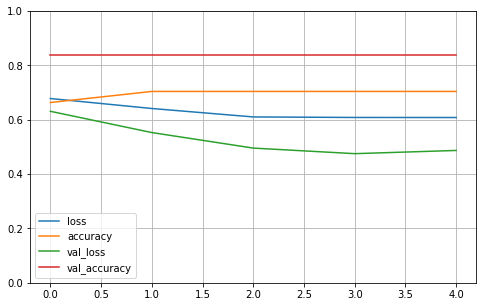

Compute valiation accuracy
2023-01-03 13:14:27.476775
Range of scores: 0.27930227 to 0.2974645
Predicted zeros and ones 92 0
Accuracy: 83.70% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:27.588808
Fold 3
Training example
[171 172 174 ...   0   0   0]
Train sizes (346, 3997) (346, 1)
Valid sizes (138, 3997) (138, 1)
Train set ones/size 91 / 346
Valid set ones/size 40 / 138
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:27.765894


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
11/11 [==============================] - 1s 24ms/step - loss: 0.6754 - accuracy: 0.7399 - val_loss: 0.6595 - val_accuracy: 0.7101
Epoch 2/5
11/11 [==============================] - 0s 12ms/step - loss: 0.6348 - accuracy: 0.7370 - val_loss: 0.6213 - val_accuracy: 0.7101
Epoch 3/5
11/11 [==============================] - 0s 12ms/step - loss: 0.5937 - accuracy: 0.7370 - val_loss: 0.6016 - val_accuracy: 0.7101
Epoch 4/5
11/11 [==============================] - 0s 13ms/step - loss: 0.5755 - accuracy: 0.7370 - val_loss: 0.6060 - val_accuracy: 0.7101
Epoch 5/5
11/11 [==============================] - 0s 11ms/step - loss: 0.5776 - accuracy: 0.7370 - val_loss: 0.6064 - val_accuracy: 0.7101


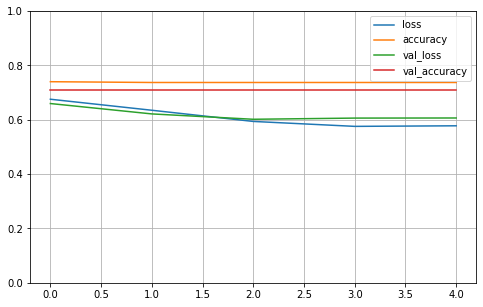

Compute valiation accuracy
2023-01-03 13:14:29.313735
Range of scores: 0.24266802 to 0.24725413
Predicted zeros and ones 138 0
Accuracy: 71.01% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:29.436085
Fold 4
Training example
[154 103 153 ...   0   0   0]
Train sizes (392, 3997) (392, 1)
Valid sizes (92, 3997) (92, 1)
Train set ones/size 102 / 392
Valid set ones/size 29 / 92
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:29.599533


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
13/13 [==============================] - 1s 21ms/step - loss: 0.6746 - accuracy: 0.7245 - val_loss: 0.6627 - val_accuracy: 0.6848
Epoch 2/5
13/13 [==============================] - 0s 11ms/step - loss: 0.6300 - accuracy: 0.7398 - val_loss: 0.6314 - val_accuracy: 0.6848
Epoch 3/5
13/13 [==============================] - 0s 12ms/step - loss: 0.5844 - accuracy: 0.7398 - val_loss: 0.6251 - val_accuracy: 0.6848
Epoch 4/5
13/13 [==============================] - 0s 11ms/step - loss: 0.5717 - accuracy: 0.7398 - val_loss: 0.6389 - val_accuracy: 0.6848
Epoch 5/5
13/13 [==============================] - 0s 12ms/step - loss: 0.5751 - accuracy: 0.7398 - val_loss: 0.6404 - val_accuracy: 0.6848


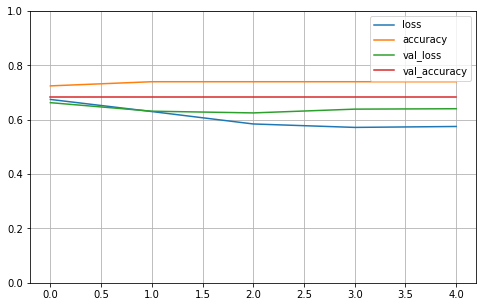

Compute valiation accuracy
2023-01-03 13:14:31.225892
Range of scores: 0.23166223 to 0.2409592
Predicted zeros and ones 92 0
Accuracy: 68.48% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:31.329626
Fold 5
Training example
[154 103 153 ...   0   0   0]
Train sizes (410, 3997) (410, 1)
Valid sizes (74, 3997) (74, 1)
Train set ones/size 103 / 410
Valid set ones/size 28 / 74
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:31.500992


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
13/13 [==============================] - 1s 21ms/step - loss: 0.6765 - accuracy: 0.7293 - val_loss: 0.6762 - val_accuracy: 0.6216
Epoch 2/5
13/13 [==============================] - 0s 11ms/step - loss: 0.6288 - accuracy: 0.7488 - val_loss: 0.6643 - val_accuracy: 0.6216
Epoch 3/5
13/13 [==============================] - 0s 12ms/step - loss: 0.5837 - accuracy: 0.7488 - val_loss: 0.6866 - val_accuracy: 0.6216
Epoch 4/5
13/13 [==============================] - 0s 11ms/step - loss: 0.5657 - accuracy: 0.7488 - val_loss: 0.7177 - val_accuracy: 0.6216
Epoch 5/5
13/13 [==============================] - 0s 11ms/step - loss: 0.5634 - accuracy: 0.7488 - val_loss: 0.7111 - val_accuracy: 0.6216


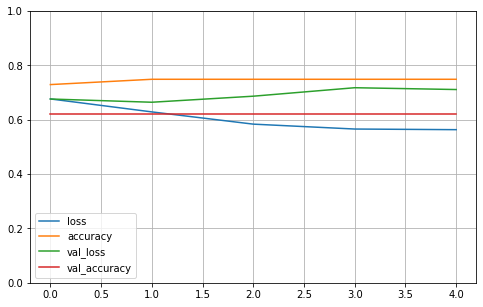

Compute valiation accuracy
2023-01-03 13:14:33.772812
Range of scores: 0.23567064 to 0.25174224
Predicted zeros and ones 74 0
Accuracy: 62.16% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:33.882338

Cross validation 5 folds 5 epochs
 accuracy mean 72.75% +/- 7.55
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:14:33.883166
-------------
2023-01-03 13:14:33.883228
Cell line for today: 13 = K562
Load RCI values...
Num RCI: 958
Load genes...
2023-01-03 13:14:33.895895
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:14:34.417691
Num IDs: 287
Count 86 ones out of 287 labels.
Num counts: 287
2023-01-03 13:14:34.418102
splitting
Fold 1
Training example
[154 103 153 ...   0   0   0]
Train sizes (245, 3997) (245, 1)
Valid sizes (42, 3997) (42, 1)
Train set ones/size 72 / 245
Valid set ones/size 14 / 42
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:34.551473
Epoch 1/5
8/8 [==============================] - 1s 32ms/step - loss: 0.6842 - accuracy: 0.6571 - val_loss: 0.6758 - val_accuracy: 0.6667
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.6607 - accuracy: 0.7061 - val_loss: 0.6578 - val_accuracy: 0.6667
Epoch 3/5
8/8 [==============================] - 0s 13ms/step - loss: 0.6368 - accuracy: 0.7061 - val_loss: 0.6431 - val_accuracy: 0.6667
Epoch 4/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6174 - accuracy: 0.7061 - val_loss: 0.6374 - val_accuracy: 0.6667
Epoch 5/5
8/8 [==============================] - 0s 13ms/step - loss: 0.6066 - accuracy: 0.7061 

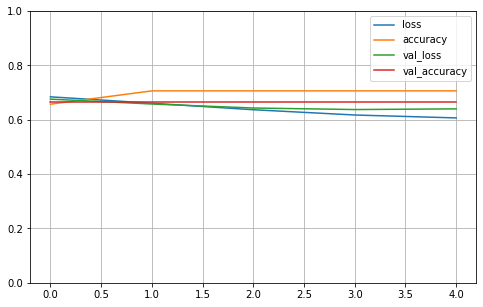

Compute valiation accuracy
2023-01-03 13:14:36.505303
Range of scores: 0.29166642 to 0.31290507
Predicted zeros and ones 42 0
Accuracy: 66.67% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:36.623126
Fold 2
Training example
[154 103 153 ...   0   0   0]
Train sizes (217, 3997) (217, 1)
Valid sizes (70, 3997) (70, 1)
Train set ones/size 76 / 217
Valid set ones/size 10 / 70
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:36.742580
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 1s 36ms/step - loss: 0.6870 - accuracy: 0.6498 - val_loss: 0.6625 - val_accuracy: 0.8571
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 0.6748 - accuracy: 0.6498 - val_loss: 0.6263 - val_accuracy: 0.8571
Epoch 3/5
7/7 [==============================] - 0s 14ms/step - loss: 0.6633 - accuracy: 0.6498 - val_loss: 0.5818 - val_accuracy: 0.8571
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.6518 - accuracy: 0.6498 - val_loss: 0.5517 - val_accuracy: 0.8571
Epoch 5/5
7/7 [==============================] - 0s 16ms/step - loss: 0.6471 - accuracy: 0.6498 - val_loss: 0.5301 - val_accuracy: 0.8571


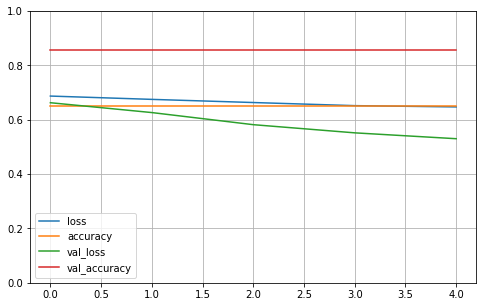

Compute valiation accuracy
2023-01-03 13:14:38.702692
Range of scores: 0.3556881 to 0.37047586
Predicted zeros and ones 70 0
Accuracy: 85.71% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:38.804453
Fold 3
Training example
[154 103 153 ...   0   0   0]
Train sizes (222, 3997) (222, 1)
Valid sizes (65, 3997) (65, 1)
Train set ones/size 57 / 222
Valid set ones/size 29 / 65
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:38.914388
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 1s 40ms/step - loss: 0.6809 - accuracy: 0.7477 - val_loss: 0.6893 - val_accuracy: 0.5538
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 0.6551 - accuracy: 0.7432 - val_loss: 0.6887 - val_accuracy: 0.5538
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.6273 - accuracy: 0.7432 - val_loss: 0.6955 - val_accuracy: 0.5538
Epoch 4/5
7/7 [==============================] - 0s 15ms/step - loss: 0.6003 - accuracy: 0.7432 - val_loss: 0.7142 - val_accuracy: 0.5538
Epoch 5/5
7/7 [==============================] - 0s 11ms/step - loss: 0.5801 - accuracy: 0.7432 - val_loss: 0.7450 - val_accuracy: 0.5538


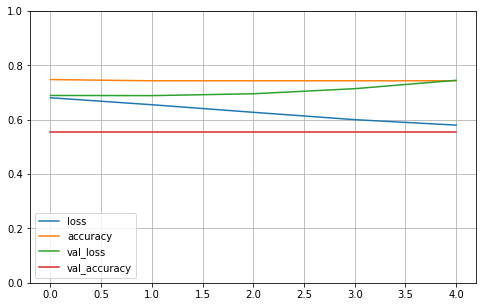

Compute valiation accuracy
2023-01-03 13:14:40.324053
Range of scores: 0.28275588 to 0.30381125
Predicted zeros and ones 65 0
Accuracy: 55.38% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:40.440549
Fold 4
Training example
[186 232 158 ...   0   0   0]
Train sizes (234, 3997) (234, 1)
Valid sizes (53, 3997) (53, 1)
Train set ones/size 61 / 234
Valid set ones/size 25 / 53
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:40.558153
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 30ms/step - loss: 0.6820 - accuracy: 0.7393 - val_loss: 0.6916 - val_accuracy: 0.5283
Epoch 2/5
8/8 [==============================] - 0s 14ms/step - loss: 0.6543 - accuracy: 0.7393 - val_loss: 0.6949 - val_accuracy: 0.5283
Epoch 3/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6246 - accuracy: 0.7393 - val_loss: 0.7091 - val_accuracy: 0.5283
Epoch 4/5
8/8 [==============================] - 0s 15ms/step - loss: 0.5956 - accuracy: 0.7393 - val_loss: 0.7425 - val_accuracy: 0.5283
Epoch 5/5
8/8 [==============================] - 0s 14ms/step - loss: 0.5785 - accuracy: 0.7393 - val_loss: 0.7916 - val_accuracy: 0.5283


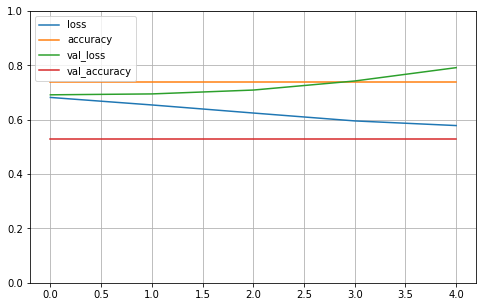

Compute valiation accuracy
2023-01-03 13:14:42.026214
Range of scores: 0.25465855 to 0.27455255
Predicted zeros and ones 53 0
Accuracy: 52.83% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:42.150467
Fold 5
Training example
[154 103 153 ...   0   0   0]
Train sizes (230, 3997) (230, 1)
Valid sizes (57, 3997) (57, 1)
Train set ones/size 78 / 230
Valid set ones/size 8 / 57
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:42.275352
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 [==============================] - 1s 31ms/step - loss: 0.6859 - accuracy: 0.6609 - val_loss: 0.6563 - val_accuracy: 0.8596
Epoch 2/5
8/8 [==============================] - 0s 15ms/step - loss: 0.6713 - accuracy: 0.6609 - val_loss: 0.6114 - val_accuracy: 0.8596
Epoch 3/5
8/8 [==============================] - 0s 14ms/step - loss: 0.6547 - accuracy: 0.6609 - val_loss: 0.5656 - val_accuracy: 0.8596
Epoch 4/5
8/8 [==============================] - 0s 12ms/step - loss: 0.6452 - accuracy: 0.6609 - val_loss: 0.5277 - val_accuracy: 0.8596
Epoch 5/5
8/8 [==============================] - 0s 13ms/step - loss: 0.6397 - accuracy: 0.6609 - val_loss: 0.5077 - val_accuracy: 0.8596


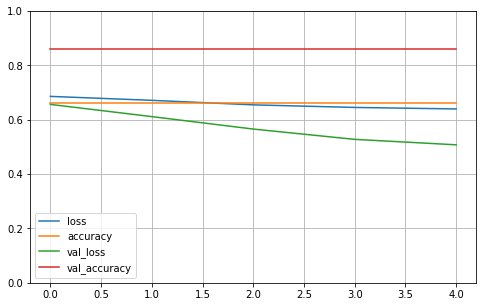

Compute valiation accuracy
2023-01-03 13:14:44.289317
Range of scores: 0.3358116 to 0.34368396
Predicted zeros and ones 57 0
Accuracy: 85.96% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:44.385907

Cross validation 5 folds 5 epochs
 accuracy mean 69.31% +/- 14.28
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:14:44.386497
-------------
2023-01-03 13:14:44.386573
Cell line for today: 14 = IMR.90
Load RCI values...
Num RCI: 390
Load genes...
2023-01-03 13:14:44.398582
Load sequence...


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2023-01-03 13:14:44.762281
Num IDs: 155
Count 61 ones out of 155 labels.
Num counts: 155
2023-01-03 13:14:44.762684
splitting
Fold 1
Training example
[171 172 174 ...   0   0   0]
Train sizes (114, 3997) (114, 1)
Valid sizes (41, 3997) (41, 1)
Train set ones/size 39 / 114
Valid set ones/size 22 / 41
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:44.857348
Epoch 1/5
4/4 [==============================] - 1s 59ms/step - loss: 0.6917 - accuracy: 0.5000 - val_loss: 0.6950 - val_accuracy: 0.4634
Epoch 2/5
4/4 [==============================] - 0s 18ms/step - loss: 0.6844 - accuracy: 0.6579 - val_loss: 0.6976 - val_accuracy: 0.4634
Epoch 3/5
4/4 [==============================] - 0s 19ms/step - loss: 0.6770 - accuracy: 0.6579 - val_loss: 0.7015 - val_accuracy: 0.4634
Epoch 4/5
4/4 [==============================] - 0s 19ms/step - loss: 0.6708 - accuracy: 0.6579 - val_loss: 0.7074 - val_accuracy: 0.4634
Epoch 5/5
4/4 [==============================] - 0s 18ms/step - loss: 0.6621 - accuracy: 0.6579 

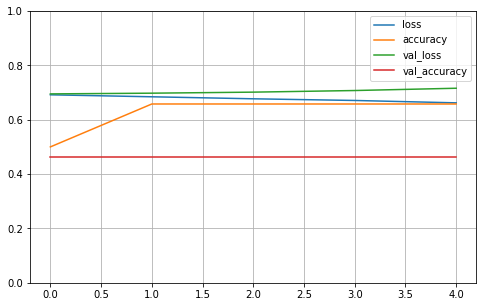

Compute valiation accuracy
2023-01-03 13:14:46.069181
Range of scores: 0.423356 to 0.4290968
Predicted zeros and ones 41 0
Accuracy: 46.34% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:46.173953
Fold 2
Training example
[171 172 174 ...   0   0   0]
Train sizes (137, 3997) (137, 1)
Valid sizes (18, 3997) (18, 1)
Train set ones/size 52 / 137
Valid set ones/size 9 / 18
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:46.250915
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - 1s 47ms/step - loss: 0.6914 - accuracy: 0.5766 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/5
5/5 [==============================] - 0s 14ms/step - loss: 0.6878 - accuracy: 0.6204 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 3/5
5/5 [==============================] - 0s 13ms/step - loss: 0.6843 - accuracy: 0.6204 - val_loss: 0.6950 - val_accuracy: 0.5000
Epoch 4/5
5/5 [==============================] - 0s 13ms/step - loss: 0.6793 - accuracy: 0.6204 - val_loss: 0.6967 - val_accuracy: 0.5000
Epoch 5/5
5/5 [==============================] - 0s 13ms/step - loss: 0.6749 - accuracy: 0.6204 - val_loss: 0.7003 - val_accuracy: 0.5000


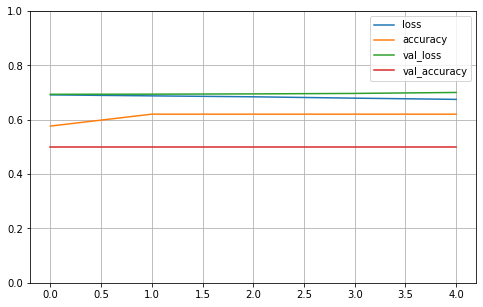

Compute valiation accuracy
2023-01-03 13:14:47.797991
Range of scores: 0.4383698 to 0.44547045
Predicted zeros and ones 18 0
Accuracy: 50.00% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:47.913059
Fold 3
Training example
[171 172 174 ...   0   0   0]
Train sizes (109, 3997) (109, 1)
Valid sizes (46, 3997) (46, 1)
Train set ones/size 45 / 109
Valid set ones/size 16 / 46
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:47.987254
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 1s 64ms/step - loss: 0.6941 - accuracy: 0.4587 - val_loss: 0.6913 - val_accuracy: 0.6522
Epoch 2/5
4/4 [==============================] - 0s 21ms/step - loss: 0.6907 - accuracy: 0.5872 - val_loss: 0.6860 - val_accuracy: 0.6522
Epoch 3/5
4/4 [==============================] - 0s 20ms/step - loss: 0.6884 - accuracy: 0.5872 - val_loss: 0.6808 - val_accuracy: 0.6522
Epoch 4/5
4/4 [==============================] - 0s 20ms/step - loss: 0.6857 - accuracy: 0.5872 - val_loss: 0.6759 - val_accuracy: 0.6522
Epoch 5/5
4/4 [==============================] - 0s 18ms/step - loss: 0.6842 - accuracy: 0.5872 - val_loss: 0.6710 - val_accuracy: 0.6522


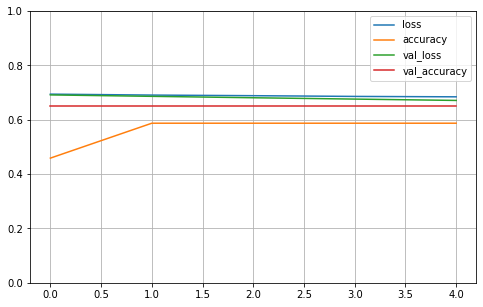

Compute valiation accuracy
2023-01-03 13:14:49.284419
Range of scores: 0.4573635 to 0.45866486
Predicted zeros and ones 46 0
Accuracy: 65.22% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:49.404090
Fold 4
Training example
[171 172 174 ...   0   0   0]
Train sizes (143, 3997) (143, 1)
Valid sizes (12, 3997) (12, 1)
Train set ones/size 57 / 143
Valid set ones/size 4 / 12
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:49.492800
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - 1s 56ms/step - loss: 0.6929 - accuracy: 0.5664 - val_loss: 0.6884 - val_accuracy: 0.6667
Epoch 2/5
5/5 [==============================] - 0s 19ms/step - loss: 0.6889 - accuracy: 0.6014 - val_loss: 0.6822 - val_accuracy: 0.6667
Epoch 3/5
5/5 [==============================] - 0s 13ms/step - loss: 0.6847 - accuracy: 0.6014 - val_loss: 0.6733 - val_accuracy: 0.6667
Epoch 4/5
5/5 [==============================] - 0s 13ms/step - loss: 0.6804 - accuracy: 0.6014 - val_loss: 0.6632 - val_accuracy: 0.6667
Epoch 5/5
5/5 [==============================] - 0s 18ms/step - loss: 0.6756 - accuracy: 0.6014 - val_loss: 0.6545 - val_accuracy: 0.6667


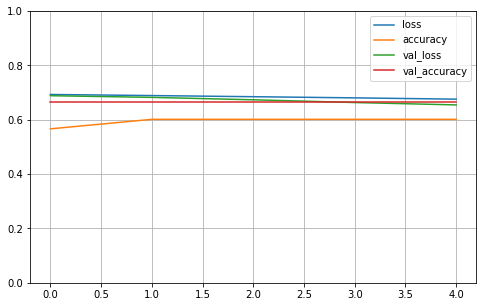

Compute valiation accuracy
2023-01-03 13:14:50.817193
Range of scores: 0.4251334 to 0.42938814
Predicted zeros and ones 12 0
Accuracy: 66.67% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:50.933649
Fold 5
Training example
[201  36 143 ...   0   0   0]
Train sizes (117, 3997) (117, 1)
Valid sizes (38, 3997) (38, 1)
Train set ones/size 51 / 117
Valid set ones/size 10 / 38
BUILD MODEL
COMPILE
FIT
2023-01-03 13:14:51.013773
Epoch 1/5


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 1s 62ms/step - loss: 0.6923 - accuracy: 0.5641 - val_loss: 0.6845 - val_accuracy: 0.7368
Epoch 2/5
4/4 [==============================] - 0s 18ms/step - loss: 0.6901 - accuracy: 0.5641 - val_loss: 0.6772 - val_accuracy: 0.7368
Epoch 3/5
4/4 [==============================] - 0s 21ms/step - loss: 0.6889 - accuracy: 0.5641 - val_loss: 0.6680 - val_accuracy: 0.7368
Epoch 4/5
4/4 [==============================] - 0s 18ms/step - loss: 0.6864 - accuracy: 0.5641 - val_loss: 0.6620 - val_accuracy: 0.7368
Epoch 5/5
4/4 [==============================] - 0s 17ms/step - loss: 0.6855 - accuracy: 0.5641 - val_loss: 0.6556 - val_accuracy: 0.7368


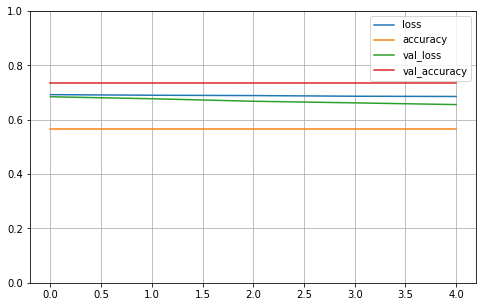

Compute valiation accuracy
2023-01-03 13:14:52.344091
Range of scores: 0.4538486 to 0.45949918
Predicted zeros and ones 38 0
Accuracy: 73.68% Precision: 0.00% Recall: 0.00% F1: 0.00%
2023-01-03 13:14:52.439721

Cross validation 5 folds 5 epochs
 accuracy mean 60.38% +/- 10.44
 precision mean 0.00% +/- 0.00
 recall mean 0.00% +/- 0.00
 F1 mean 0.00% +/- 0.00
2023-01-03 13:14:52.442745


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
for CELL_LINE_NUMBER in range(15):
    print('-------------')
    print(datetime.now())
    cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
    print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)
    print("Load RCI values...")
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
    print('Num RCI:', len(gene_to_rci.keys()))
    #print('Example RCI:', list(gene_to_rci.items())[:3])
    print("Load genes...")
    all_genes = list(gene_to_rci.keys())
    print(datetime.now())
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    labels,allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM
    print(datetime.now())
    print('Num IDs:',len(allids))
    #print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
    print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
    #print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
    print('Num counts:',len(allseq))
    #print('Example sequence:',allseq[3])
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
    print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
    print(datetime.now())